In [58]:
# Importing necessary libraries
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import anndata as ad
import scanpy as sc
from scipy.stats import uniform, randint
from sklearn.model_selection import ParameterSampler
from sklearn.manifold import TSNE, trustworthiness
import umap
from sklearn.metrics import pairwise_distances
import itertools
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from gprofiler import GProfiler
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../src')
from codebase import GCSingleCellAnalysis

# Introduction

The main goal of this notebook is to recreate and enrich the gastric (GC) cancer single-cell RNA-seq (scRNA-seq) data analysis approach described in the ["Comprehensive analysis of metastatic gastric cancer tumour cells using single‑cell RNA‑seq" by Wang B. et. al](https://www.nature.com/articles/s41598-020-80881-2), using the raw counts matrix that is available in [GEO (GSE158631)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE158631). The authors' code was not available.

The data analysis steps include:

* __Data preprocessing__ (QC metrics calculation, normalization, filtering)
* __Dimensionality reduction__ (PCA, t-SNE, UMAP)
* __CLustering__ (GMMs, Average Link, Ward, Spectral, Louvain, Leiden)
* __Post-Clustering analysis__ (marker gene identification, functional annotation of the clusters using Gene Ontology) 

## The `GCSingleCellAnalysis` Class

The `GCSingleCellAnalysis` class is designed to handle this GC scRNA-seq data analysis pipeline, leveraging the [Annotated Data (AnnData)](https://anndata.readthedocs.io/en/latest/) object and the [Single-Cell Analysis in Python (Scanpy)](https://scanpy.readthedocs.io/en/stable/) library for preprocessing, dimensionality reduction, clustering, and post-clustering analysis. Here's a detailed breakdown of its methods:

__Initialization and Data Management__
* `__init__(self, filepath=None)`: Initializes the class by loading a CSV file into a pandas DataFrame and then converting it to an AnnData object.
* `save_adata(self, filename)`: Saves the AnnData object to a specified h5ad file (format for storing annotated data).
* `load_adata(self, filename)`: Loads an AnnData object from a specified h5ad file.

__Preprocessing__
* `preprocess_adata(self)`: Adds mitochondrial, ribosomal, and hemoglobin gene information and calculates quality control metrics.
* `normalize_adata(self)`: Normalizes the data using TPM and log2 transformation if it contains raw counts.
* `filter_adata(self, ribosomal_threshold=50, mitochondrial_threshold=20`): Filters the data based on specified thresholds for gene expression levels and ribosomal and mitochondrial content.
* `prepare_adata(self)`: Prepares the AnnData object by extracting patient ID and tissue type, and combines them into a 'cell_type' column.

__Dimensionality Reduction__
* `perform_pca(self, n_comps=50)`: Performs Principal Component Analysis (PCA) on the dataset.
* `determine_optimal_pcs(self, variance_threshold=0.90)`: Determines the optimal number of principal components to capture a specified percent of explained variance.
* `prepare_pca_reduced_adata(self, variance_threshold=0.90)`: Prepares the reduced dataset by retaining the optimal number of PCs.
* `plot_pca(self)`: Plots pairwise PCA scatter plots and histograms for the first three PCs.
* `optimize_tsne(self, n_iter=30, random_state=42)`: Optimizes t-SNE hyperparameters based on the trustworthiness metric.
* `perform_tsne(self, optimize=False, n_iter=30, random_state=42, **kwargs)`: Performs t-SNE on the dataset (hyperparameter optimization optional).
* `plot_tsne(self)`: Plots the t-SNE results.
* `optimize_umap(self, n_iter=30, random_state=42)`: Optimizes UMAP hyperparameters based on the trustworthiness metric.
* `perform_umap(self, optimize=False, n_iter=30, random_state=42, **kwargs)`: Performs UMAP on the dataset (hyperparameter optimization optional).
* `plot_umap(self)`: Plots the UMAP results.

__Clustering__
* `apply_clustering(self, data, method='gmm', n_clusters=4, embedding='X_pca', optimize=False)`: Applies clustering using specified methods (e.g., GMM, Average Linkage, Ward, Spectral, Louvain, Leiden) (cluster number optimization optional).
* `evaluate_clustering(self, labels, data)`: Evaluates clustering using Silhouette, Calinski-Harabasz, and Davies-Bouldin scores.
* `cluster_and_evaluate(self, methods, embeddings=['X_pca'], optimize=False)`: Clusters and evaluates data using specified methods and embeddings.
* `create_results_dataframe(self, results)`: Creates a DataFrame from clustering results.
* `plot_clustering_evaluation(self, results_df)`: Generates a bar plot to evaluate clustering results.

__Post-Clustering Analysis__
* `analyze_and_plot_markers(self, group_key, method='wilcoxon', n_genes=10, filename='marker_genes.csv', figsize=(10, 7))`: Analyzes marker genes and plots a heatmap of the top genes.
* `fetch_go_annotations(self, group_key, method='wilcoxon', n_genes=10, organism='hsapiens')`: Fetches GO annotations for top marker genes using `gprofiler`.
* `print_go_annotations(self, go_annotations)`: Prints GO annotations.

# 1. Preprocessing - Quality Control - Filtering

We begin our analysis by initializing a `GCSingleCellAnalysis` object using the `GSE158631_count.csv` raw counts matrix. This counts matrix was produced by the authors after using the following tools on their raw data (which they got by performing single-cell sequencing from primary gastric cancer and paired metastatic lymph node tissue samples obtained from three patients):

* __Trimmomatic__: Trimming sequencing adapters and removing low-quality reads (Phred < 20).
* __HiSat2__: Mapping reads to the human genome reference (UCSC hg19).
* __FeatureCounts__: Calculating expression levels of genes, producing raw count values for each gene in each cell.

In [59]:
# Initializing the GCSingleCellAnalysis object
analysis = GCSingleCellAnalysis('../data/GSE158631_count.csv')

In [60]:
print(analysis.adata) # checking the shape of the AnnData object (cells x genes)
analysis.adata.to_df() # displaying the AnnData object as a dataframe

AnnData object with n_obs × n_vars = 94 × 21196


THY1  DCN  COL1A1  COL1A2  COL6A1  COL6A2  COL6A3  PECAM1  VWF  \
GC1-TT1      0    0       0       1       0       0       1      10   11   
GC1-TT2      0    0       0       1       0       0       0       1    3   
GC1-TT3      0    0       0       1       0       0      12       0   14   
GC1-TT4      0    0       0      10       0       0       1       2    0   
GC1-TT5      0    0       0       5       0       0      13       0    0   
...        ...  ...     ...     ...     ...     ...     ...     ...  ...   
GC3-LN8      0    1       0       7       0       0       0       0    6   
GC3-LN9      1    0       7       5       1       0       1       0    0   
GC3-LN10     0    0       0       0       1       0       1       0    1   
GC3-LN11     0    2       2       1       2       0       1       0    2   
GC3-LN12     0    0       0       0       0       0       0       0   26   

          CDH5  ...  RPS4Y2  RBMY2EP  TTTY13  TTTY6  TTTY5  RBMY2FP  DAZ1  \
GC1-TT1      0  ...       0        0       0      0      0        0     0   
GC1-TT2      0  ...       0        0       0      0      2        0     0   
GC1-TT3      0  ...       0        0       2      0      0        0     1   
GC1-TT4      4  ...       0        1       0      0      0        3     0   
GC1-TT5      0  ...       0        0       0      0      0        0     0   
...        ...  ...     ...      ...     ...    ...    ...      ...   ...   
GC3-LN8      0  ...       0        0       0      0      0        0     0   
GC3-LN9      0  ...       0        0       0      0      0        0     0   
GC3-LN10     0  ...       0        0       0      0      0        0     0   
GC3-LN11     0  ...       0        0       0      0      0        0     0   
GC3-LN12     0  ...       0        0       0      0      0        0     0   

          DAZ4  DAZ2  DAZ3  
GC1-TT1      0     0     1  
GC1-TT2      0     0     1  
GC1-TT3      0     0     0  
GC1-TT4      1     0     1  
GC1-TT5      0     0     4  
...        ...   ...   ...  
GC3-LN8      0     0     0  
GC3-LN9      0     0     1  
GC3-LN10     0     0     0  
GC3-LN11     0     0     1  
GC3-LN12     0     0     0  

[94 rows x 21196 columns]

We begin our preprocessing by extracting information about mitochondrial, ribosomal and hemoglobin genes, as well as calculating quality control (QC) metrics. Using the `preprocess_adata()` method, we calculate several QC metrics for each cell and each gene, including:

For Each Cell:
* Total counts: The total number of read counts for each cell.
* Total counts for each QC variable: The total number of read counts for mitochondrial, ribosomal, and hemoglobin genes for each cell.
* Percentage counts for each QC variable: The percentage of total read counts that come from mitochondrial, ribosomal, and hemoglobin genes for each cell.
* Number of genes: The number of detected genes for each cell.
* Number of genes for each QC variable: The number of detected mitochondrial, ribosomal, and hemoglobin genes for each cell.

For Each Gene:
* Total counts: The total number of read counts for each gene.
* Number of cells: The number of cells in which each gene is detected.
* Mean counts: The average number of read counts for each gene.
* Percentage counts: The percentage of total read counts that come from each gene.

Regarding the importance of the aforementioned gene types:

* __Mitochondrial Genes__: high expression of mitochondrial genes can indicate stressed or dying cells, as these cells often have increased mitochondrial activity. Cells with a high proportion of mitochondrial gene expression can be filtered out to improve the quality of the dataset.
* __Ribosomal Genes__: cells with a very high proportion of ribosomal gene expression may indicate technical artifacts, such as doublets (two cells being captured as one), high background noise, or sequencing biases. Filtering out cells with excessively high ribosomal content helps to focus the analysis on the biologically relevant cells, ensuring that downstream analyses like clustering and differential expression are not confounded by these artifacts.
* __Hemoglobin Genes__: hemoglobin levels are associated with tumor progression and prognosis of gastric cancer, thus cells expressing hemoglobin genes might have clinical relevance. Including cells with hemoglobin gene expression in our analysis might help in identifying a subpopulation of cells that are significant in gastric cancer patients based on the differential gene expression levels of hemoglobin genes.

In [61]:
# Preprocessing the data and calculating QC metrics
analysis.preprocess_adata()

In [62]:
# Displaying the QC metrics for each cell
analysis.adata.obs

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
GC1-TT1                4584                 8.430545         15044   
GC1-TT2                5153                 8.547528         24631   
GC1-TT3                5633                 8.636575         19521   
GC1-TT4                4958                 8.508959         20751   
GC1-TT5                3960                 8.284252         16139   
...                     ...                      ...           ...   
GC3-LN8                3760                 8.232440          9270   
GC3-LN9                4663                 8.447629         11077   
GC3-LN10               4178                 8.337827          9912   
GC3-LN11               3590                 8.186186         10841   
GC3-LN12               1625                 7.393878          7607   

          log1p_total_counts  pct_counts_in_top_50_genes  \
GC1-TT1             9.618801                   10.821590   
GC1-TT2            10.111802                    7.904673   
GC1-TT3             9.879297                    6.838789   
GC1-TT4             9.940398                    8.674281   
GC1-TT5             9.689056                   10.558275   
...                      ...                         ...   
GC3-LN8             9.134647                    9.719525   
GC3-LN9             9.312716                    6.752731   
GC3-LN10            9.201602                    7.627119   
GC3-LN11            9.291183                    9.750023   
GC3-LN12            8.936956                   23.294334   

          pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
GC1-TT1                     15.919968                    23.756980   
GC1-TT2                     13.231294                    21.326783   
GC1-TT3                     11.479945                    18.718303   
GC1-TT4                     14.211363                    22.476025   
GC1-TT5                     16.103848                    24.852841   
...                               ...                          ...   
GC3-LN8                     14.994606                    22.718447   
GC3-LN9                     10.887424                    17.703349   
GC3-LN10                    12.378935                    19.733656   
GC3-LN11                    15.810350                    24.942348   
GC3-LN12                    34.810043                    49.533325   

          pct_counts_in_top_500_genes  total_counts_mt  log1p_total_counts_mt  \
GC1-TT1                     40.268546                0                    0.0   
GC1-TT2                     37.793837                0                    0.0   
GC1-TT3                     33.722658                0                    0.0   
GC1-TT4                     39.540263                0                    0.0   
GC1-TT5                     42.920875                0                    0.0   
...                               ...              ...                    ...   
GC3-LN8                     39.212513                0                    0.0   
GC3-LN9                     32.734495                0                    0.0   
GC3-LN10                    35.794996                0                    0.0   
GC3-LN11                    43.252467                0                    0.0   
GC3-LN12                    73.287761                0                    0.0   

          pct_counts_mt  total_counts_ribo  log1p_total_counts_ribo  \
GC1-TT1             0.0                145                 4.983607   
GC1-TT2             0.0                106                 4.672829   
GC1-TT3             0.0                 81                 4.406719   
GC1-TT4             0.0                 57                 4.060443   
GC1-TT5             0.0                161                 5.087596   
...                 ...                ...                      ...   
GC3-LN8             0.0                 24                 3.218876   
GC3-LN9             0.0                 38                 3.66356

In [63]:
# Displaying the QC metrics for each gene
analysis.adata.var

mt   ribo     hb  n_cells_by_counts  mean_counts  \
THY1     False  False  False                 22     0.904255   
DCN      False  False  False                 32     0.936170   
COL1A1   False  False  False                 36     1.489362   
COL1A2   False  False  False                 56     2.765957   
COL6A1   False  False  False                 13     0.712766   
...        ...    ...    ...                ...          ...   
RBMY2FP  False  False  False                  7     0.159574   
DAZ1     False  False  False                  3     0.031915   
DAZ4     False  False  False                  3     0.031915   
DAZ2     False  False  False                  5     0.053191   
DAZ3     False  False  False                 49     0.819149   

         log1p_mean_counts  pct_dropout_by_counts  total_counts  \
THY1              0.644091              76.595745            85   
DCN               0.660712              65.957447            88   
COL1A1            0.912026              61.702128           140   
COL1A2            1.326002              40.425532           260   
COL6A1            0.538110              86.170213            67   
...                    ...                    ...           ...   
RBMY2FP           0.148053              92.553191            15   
DAZ1              0.031416              96.808511             3   
DAZ4              0.031416              96.808511             3   
DAZ2              0.051825              94.680851             5   
DAZ3              0.598369              47.872340            77   

         log1p_total_counts  
THY1               4.454347  
DCN                4.488636  
COL1A1             4.948760  
COL1A2             5.564520  
COL6A1             4.219508  
...                     ...  
RBMY2FP            2.772589  
DAZ1               1.386294  
DAZ4               1.386294  
DAZ2               1.791759  
DAZ3               4.356709  

[21196 rows x 9 columns]

Our next step, in accordance to the authors' pipeline, is to normalize the read counts of our counts matrix to __TPM (transcripts per million)__ and perform __log2 transformation__. TPM normalizes RNA-seq data by considering gene length and sequencing depth, while log2 transformations stabilize variance and normalize data distributions, both of which enhance the comparability and interpretability of our scRNA-seq data​set. 

The `normalize_adata()` method also checks whether or not the input data is already normalized or not, and proceeds with normalization or skips it accordingly.

In [64]:
# Normalizing the data (TPM and log2 transformation)
analysis.normalize_adata()

Data was normalized to TPM and log2 transformed.


In [65]:
print(analysis.adata) # checking the shape of the AnnData object (cells x genes)
analysis.adata.to_df() # displaying the AnnData object as a dataframe

AnnData object with n_obs × n_vars = 94 × 21196
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


THY1       DCN    COL1A1    COL1A2    COL6A1  COL6A2    COL6A3  \
GC1-TT1   0.000000  0.000000  0.000000  6.076210  0.000000     0.0  6.076210   
GC1-TT2   0.000000  0.000000  0.000000  5.378485  0.000000     0.0  0.000000   
GC1-TT3   0.000000  0.000000  0.000000  5.706721  0.000000     0.0  9.266137   
GC1-TT4   0.000000  0.000000  0.000000  8.915594  0.000000     0.0  5.620306   
GC1-TT5   0.000000  0.000000  0.000000  8.279882  0.000000     0.0  9.655535   
...            ...       ...       ...       ...       ...     ...       ...   
GC3-LN8   0.000000  6.766527  0.000000  9.562479  0.000000     0.0  0.000000   
GC3-LN9   6.512182  0.000000  9.305925  8.821410  6.512182     0.0  6.512182   
GC3-LN10  0.000000  0.000000  0.000000  0.000000  6.670838     0.0  6.670838   
GC3-LN11  0.000000  7.535157  7.535157  6.542914  7.535157     0.0  6.542914   
GC3-LN12  0.000000  0.000000  0.000000  0.000000  0.000000     0.0  0.000000   

            PECAM1        VWF     CDH5  ...  RPS4Y2   RBMY2EP    TTTY13  \
GC1-TT1   9.378765   9.516071  0.00000  ...     0.0  0.000000  0.000000   
GC1-TT2   5.378485   6.940140  0.00000  ...     0.0  0.000000  0.000000   
GC1-TT3   0.000000   9.488194  0.00000  ...     0.0  0.000000  6.692842   
GC1-TT4   6.605567   0.000000  7.59814  ...     0.0  5.620306  0.000000   
GC1-TT5   0.000000   0.000000  0.00000  ...     0.0  0.000000  0.000000   
...            ...        ...      ...  ...     ...       ...       ...   
GC3-LN8   0.000000   9.340405  0.00000  ...     0.0  0.000000  0.000000   
GC3-LN9   0.000000   0.000000  0.00000  ...     0.0  0.000000  0.000000   
GC3-LN10  0.000000   6.670838  0.00000  ...     0.0  0.000000  0.000000   
GC3-LN11  0.000000   7.535157  0.00000  ...     0.0  0.000000  0.000000   
GC3-LN12  0.000000  11.739318  0.00000  ...     0.0  0.000000  0.000000   

          TTTY6    TTTY5   RBMY2FP      DAZ1      DAZ4  DAZ2      DAZ3  
GC1-TT1     0.0  0.00000  0.000000  0.000000  0.000000   0.0  6.076210  
GC1-TT2     0.0  6.36104  0.000000  0.000000  0.000000   0.0  5.378485  
GC1-TT3     0.0  0.00000  0.000000  5.706721  0.000000   0.0  0.000000  
GC1-TT4     0.0  0.00000  7.185583  0.000000  5.620306   0.0  5.620306  
GC1-TT5     0.0  0.00000  0.000000  0.000000  0.000000   0.0  7.959114  
...         ...      ...       ...       ...       ...   ...       ...  
GC3-LN8     0.0  0.00000  0.000000  0.000000  0.000000   0.0  0.000000  
GC3-LN9     0.0  0.00000  0.000000  0.000000  0.000000   0.0  6.512182  
GC3-LN10    0.0  0.00000  0.000000  0.000000  0.000000   0.0  0.000000  
GC3-LN11    0.0  0.00000  0.000000  0.000000  0.000000   0.0  6.542914  
GC3-LN12    0.0  0.00000  0.000000  0.000000  0.000000   0.0  0.000000  

[94 rows x 21196 columns]

After normalization, we use the `filter_adata()` method, which applies the following filters to our dataset:
* __Gene filter__: average number of reads mapped to a gene must be >1 across all cells
* __Cells with high mitochondrial gene expression filter__: 20%, meaning if more than 20% of a cell's total gene expression counts come from mitochondrial genes, that cell would be filtered out. This value can be adjusted based on the specific dataset and the goals of the analysis.
* __Cells with high ribosomal gene expression filter__: 50% threshold (similar logic, also adjustable value)

In [66]:
# Filtering the data based on the QC metrics
analysis.filter_adata(ribosomal_threshold=50, mitochondrial_threshold=20) # 50% threshold for ribosomal genes and 20% threshold for mitochondrial genes

Number of genes before applying gene filtering: 21196
Number of genes after applying gene filtering: 11500
Number of cells before filtering high mitochondrial content: 94
Number of cells after filtering high mitochondrial content: 94
Number of cells before filtering high ribosomal content: 94
Number of cells after filtering high ribosomal content: 94


In [67]:
print(analysis.adata) # checking the shape of the AnnData object (cells x genes)
analysis.adata.to_df() # displaying the AnnData object as a dataframe

View of AnnData object with n_obs × n_vars = 94 × 11500
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


THY1       DCN    COL1A1    COL1A2    COL6A1  COL6A2    COL6A3  \
GC1-TT1   0.000000  0.000000  0.000000  6.076210  0.000000     0.0  6.076210   
GC1-TT2   0.000000  0.000000  0.000000  5.378485  0.000000     0.0  0.000000   
GC1-TT3   0.000000  0.000000  0.000000  5.706721  0.000000     0.0  9.266137   
GC1-TT4   0.000000  0.000000  0.000000  8.915594  0.000000     0.0  5.620306   
GC1-TT5   0.000000  0.000000  0.000000  8.279882  0.000000     0.0  9.655535   
...            ...       ...       ...       ...       ...     ...       ...   
GC3-LN8   0.000000  6.766527  0.000000  9.562479  0.000000     0.0  0.000000   
GC3-LN9   6.512182  0.000000  9.305925  8.821410  6.512182     0.0  6.512182   
GC3-LN10  0.000000  0.000000  0.000000  0.000000  6.670838     0.0  6.670838   
GC3-LN11  0.000000  7.535157  7.535157  6.542914  7.535157     0.0  6.542914   
GC3-LN12  0.000000  0.000000  0.000000  0.000000  0.000000     0.0  0.000000   

            PECAM1        VWF     CDH5  ...      PRKY    TTTY15     USP9Y  \
GC1-TT1   9.378765   9.516071  0.00000  ...  6.076210  0.000000  6.076210   
GC1-TT2   5.378485   6.940140  0.00000  ...  5.378485  0.000000  5.378485   
GC1-TT3   0.000000   9.488194  0.00000  ...  0.000000  5.706721  5.706721   
GC1-TT4   6.605567   0.000000  7.59814  ...  0.000000  9.499560  0.000000   
GC1-TT5   0.000000   0.000000  0.00000  ...  0.000000  6.964900  6.964900   
...            ...        ...      ...  ...       ...       ...       ...   
GC3-LN8   0.000000   9.340405  0.00000  ...  0.000000  0.000000  0.000000   
GC3-LN9   0.000000   0.000000  0.00000  ...  0.000000  0.000000  7.504257   
GC3-LN10  0.000000   6.670838  0.00000  ...  6.670838  0.000000  0.000000   
GC3-LN11  0.000000   7.535157  0.00000  ...  0.000000  0.000000  7.535157   
GC3-LN12  0.000000  11.739318  0.00000  ...  0.000000  0.000000  0.000000   

             DDX3Y       UTY    NLGN4Y      CD24    BCORP1     KDM5D      DAZ3  
GC1-TT1   7.065479  0.000000  0.000000  7.065479  0.000000  9.516071  6.076210  
GC1-TT2   5.378485  8.517249  6.361040  0.000000  0.000000  0.000000  5.378485  
GC1-TT3   7.685853  5.706721  8.682345  0.000000  0.000000  0.000000  0.000000  
GC1-TT4   0.000000  7.185583  0.000000  5.620306  0.000000  0.000000  5.620306  
GC1-TT5   0.000000  9.277560  0.000000  0.000000  0.000000  0.000000  7.959114  
...            ...       ...       ...       ...       ...       ...       ...  
GC3-LN8   0.000000  6.766527  0.000000  0.000000  0.000000  0.000000  0.000000  
GC3-LN9   0.000000  9.667989  0.000000  0.000000  8.086569  0.000000  6.512182  
GC3-LN10  0.000000  6.670838  0.000000  6.670838  0.000000  0.000000  0.000000  
GC3-LN11  0.000000  7.535157  0.000000  0.000000  0.000000  0.000000  6.542914  
GC3-LN12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[94 rows x 11500 columns]

After filtering, our dataset contains 94 cells and 11,500 genes.

For the final step of preprocessing, we use the `prepare_adata()` method, which adds 3 new columns to the AnnData object, useful for dimentionality reduction and clustering: 'patient', 'tissue' and 'cell_type'. In addition, it also uses the 'cell_type' column to rename the index of the dataset, using 'cell_id' as a header.

In [68]:
analysis.prepare_adata() # preparing the AnnData object for further analysis
analysis.adata.obs # displaying the AnnData cell metadata after preparation

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
cell_id                                                              
GC1-TT1                4584                 8.430545         15044   
GC1-TT2                5153                 8.547528         24631   
GC1-TT3                5633                 8.636575         19521   
GC1-TT4                4958                 8.508959         20751   
GC1-TT5                3960                 8.284252         16139   
...                     ...                      ...           ...   
GC3-LN8                3760                 8.232440          9270   
GC3-LN9                4663                 8.447629         11077   
GC3-LN10               4178                 8.337827          9912   
GC3-LN11               3590                 8.186186         10841   
GC3-LN12               1625                 7.393878          7607   

          log1p_total_counts  pct_counts_in_top_50_genes  \
cell_id                                                    
GC1-TT1             9.618801                   10.821590   
GC1-TT2            10.111802                    7.904673   
GC1-TT3             9.879297                    6.838789   
GC1-TT4             9.940398                    8.674281   
GC1-TT5             9.689056                   10.558275   
...                      ...                         ...   
GC3-LN8             9.134647                    9.719525   
GC3-LN9             9.312716                    6.752731   
GC3-LN10            9.201602                    7.627119   
GC3-LN11            9.291183                    9.750023   
GC3-LN12            8.936956                   23.294334   

          pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
cell_id                                                              
GC1-TT1                     15.919968                    23.756980   
GC1-TT2                     13.231294                    21.326783   
GC1-TT3                     11.479945                    18.718303   
GC1-TT4                     14.211363                    22.476025   
GC1-TT5                     16.103848                    24.852841   
...                               ...                          ...   
GC3-LN8                     14.994606                    22.718447   
GC3-LN9                     10.887424                    17.703349   
GC3-LN10                    12.378935                    19.733656   
GC3-LN11                    15.810350                    24.942348   
GC3-LN12                    34.810043                    49.533325   

          pct_counts_in_top_500_genes  total_counts_mt  log1p_total_counts_mt  \
cell_id                                                                         
GC1-TT1                     40.268546                0                    0.0   
GC1-TT2                     37.793837                0                    0.0   
GC1-TT3                     33.722658                0                    0.0   
GC1-TT4                     39.540263                0                    0.0   
GC1-TT5                     42.920875                0                    0.0   
...                               ...              ...                    ...   
GC3-LN8                     39.212513                0                    0.0   
GC3-LN9                     32.734495                0                    0.0   
GC3-LN10                    35.794996                0                    0.0   
GC3-LN11                    43.252467                0                    0.0   
GC3-LN12                    73.287761                0                    0.0   

          pct_counts_mt  total_counts_ribo  log1p_total_counts_ribo  \
cell_id                                                               
GC1-TT1             0.0                145                 4.983607   
GC1-TT2             0.0                106                 4.672829   
GC1-TT3             0.0                 81                 4.406719  

Now that the filtering is complete, we can get a preliminary idea of the top 20 most highly expressed genes in our dataset, which can provide context for downstream analysis.

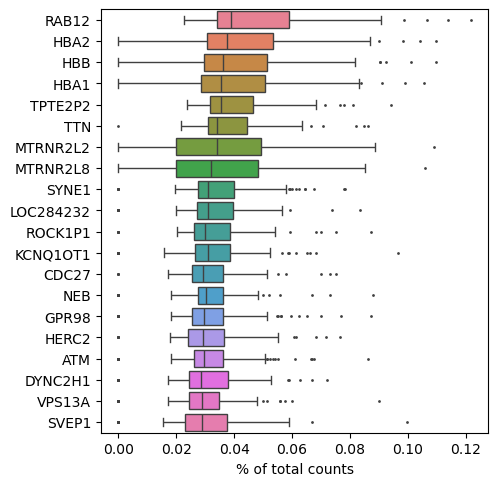

In [69]:
# Visualizing the top 20 most highly expressed genes
sc.pl.highest_expr_genes(analysis.adata, n_top=20)

# 2. Dimensionality Reduction

While the authors used PCA for dimensionality reduction and t-SNE to visualize the reduced 2D dataset (and the clustering results later), our approach utilizes different methods for dimensionality reduction and visualization of the reduced 2D dataset (including PCA, t-SNE and UMAP) separately from each other, in order to experiment and determine the best results by the end of our analysis.

## 2.1. Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms high-dimensional data into a set of orthogonal components, capturing the most significant variance within the data. In scRNA-seq analysis, PCA helps to simplify the complexity of gene expression data, making it easier to visualize and interpret by reducing noise and highlighting key patterns and clusters of cell populations, thereby aiding in the identification of distinct cellular states and subpopulations.

The `perform_pca` method performs PCA on our preprocessed dataset, with a specified number of components (85 in our case).

In [70]:
# Performing PCA on the preprocessed dataset with 85 components
analysis.perform_pca(n_comps=85)

PCA completed with 85 components.


To optimize the number of components to retain, we use the `prepare_pca_reduced_adata` method, which utilizes the `determine_optimal_pcs` method, in order to determine the optimal number of principal components (PCs) needed to explain our chosen percentage of cumulative explained variance (90% in our case).

Total Cumulative Variance with chosen number of components: 94.02%
To explain 70% of the variance, 59 components are required.
To explain 80% of the variance, 69 components are required.
To explain 90% of the variance, 81 components are required.
Number of PCs to explain the chosen 90% variance: 81


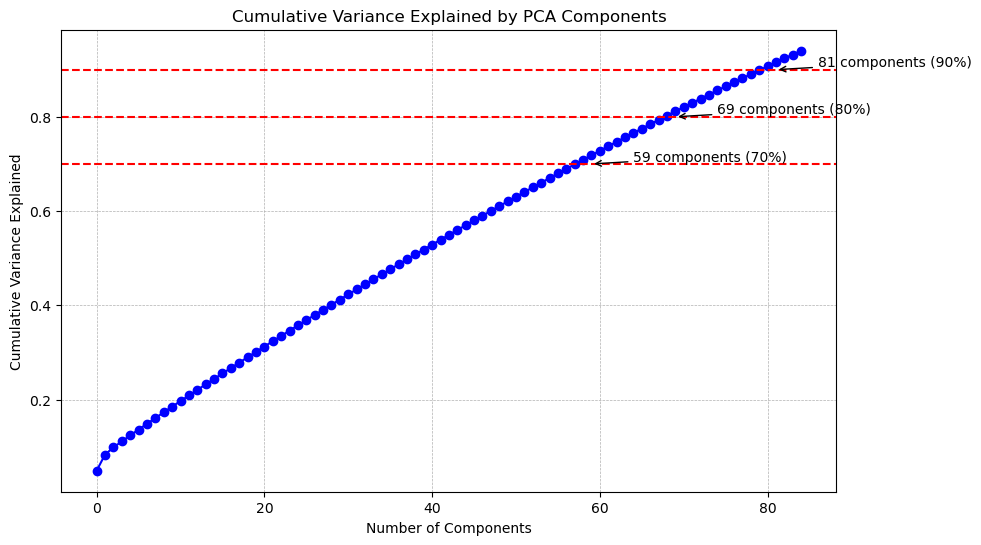

PCA completed with 81 components.
Shape of PCA results: (94, 81)


In [71]:
# Performing PCA on the preprocessed dataset with the computed optimal number of components
analysis.prepare_pca_reduced_adata(variance_threshold=0.90)

After the optimal number of PCs is determined (81 in our case), we use the `plot_pca` method to visualize the PCA-reduced dataset in a pairplot using the first 3 PCs, similarly to the authors.

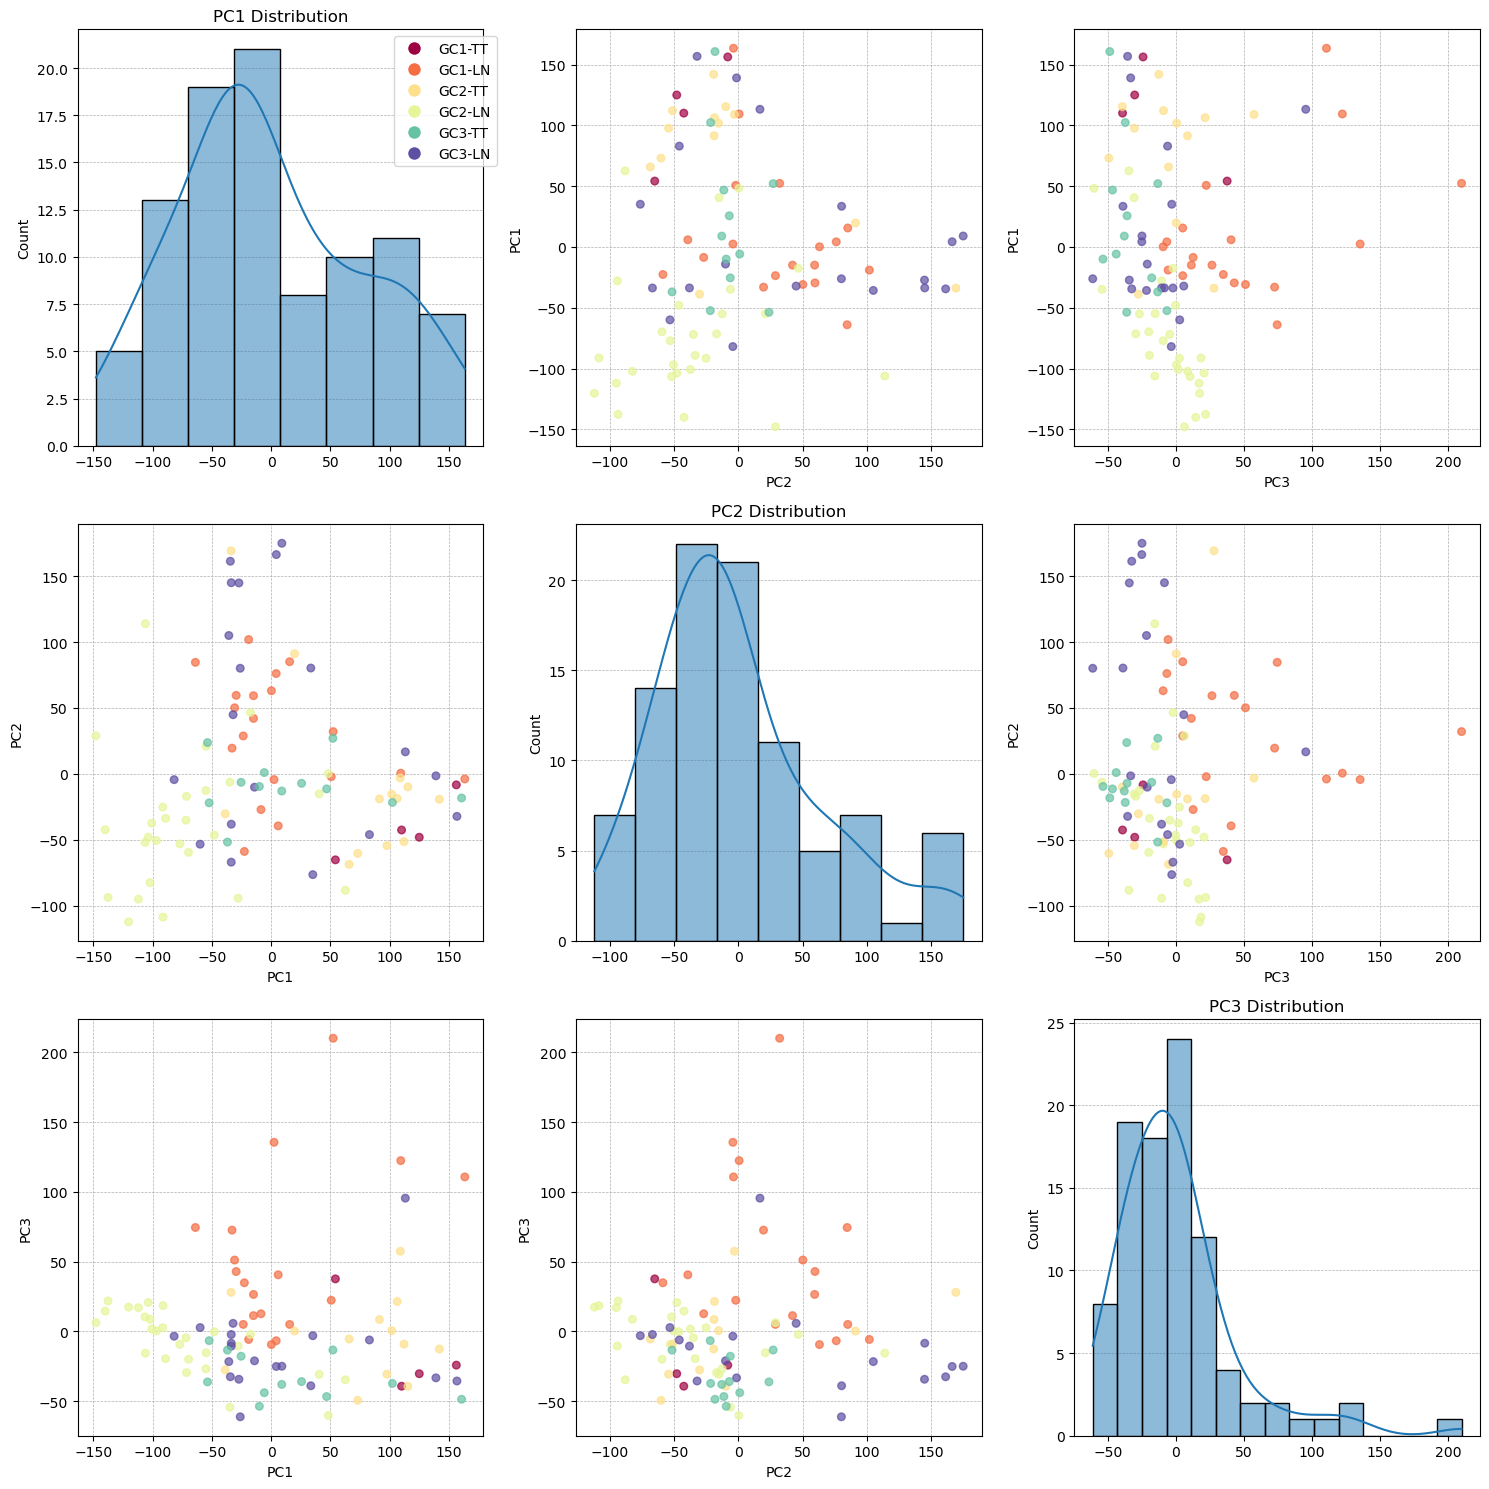

In [72]:
# Plotting the PCA results in a pairplot
analysis.plot_pca()

## 2.2. t-distributed Stochastic Neighbor Embedding (t-SNE)

t-SNE (t-distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality reduction technique that visualizes high-dimensional data by converting similarities between data points into probabilities and mapping them in a lower-dimensional space. In scRNA-seq analysis, t-SNE is particularly useful for its ability to preserve local structure, enabling the identification and visualization of distinct cellular populations and subtle differences between cell types, which can reveal clusters and patterns that might not be apparent with linear techniques like PCA.

The `perform_tsne` method performs t-SNE on the preprocessed dataset with our chosen parameters (which we determined though trial and error to achieve a 2D visualization of the dataset with good separability), and the reduced dataset is then plotted in 2D using the `plot_tsne` method.

Here, the user could optinally utilize the `optimize_tsne` method, by using `optimize=True` as an argument when running `perform_tsne`, in order to test different parameter combinations and find the combination with the highest `sklearn.manifold.trustworthiness` score.

t-SNE completed.


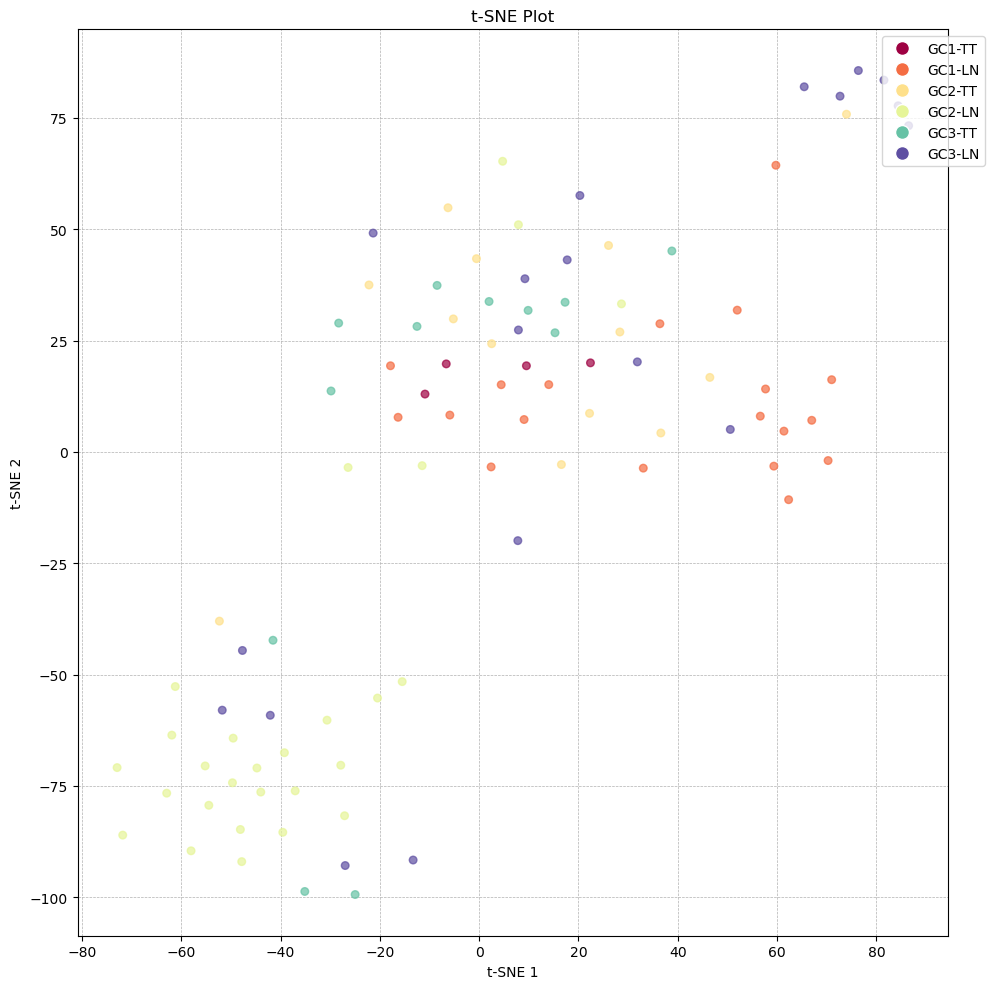

In [73]:
analysis.perform_tsne(optimize=False, perplexity=5, n_iter=5000, random_state=42) # performing t-SNE on the preprocessed dataset with our chosen parameters
analysis.plot_tsne() # plotting the t-SNE results

## 2.3. Uniform Manifold Approximation and Projection (UMAP)

UMAP (Uniform Manifold Approximation and Projection) is a nonlinear dimensionality reduction technique that maps high-dimensional data into a lower-dimensional space by preserving both local and global data structure. In scRNA-seq analysis, UMAP is particularly useful for its ability to maintain the relationships between cells, enabling the identification and visualization of complex cellular heterogeneity and subpopulations. This method enhances the interpretability of single-cell data by revealing distinct clusters and continuous structures, facilitating insights into cellular differentiation and state transitions, so we expect that it will perform even better than t-SNE.

The `perform_UMAP` method performs UMAP on the preprocessed dataset with our chosen parameters (which we determined though trial and error to achieve a 2D visualization of the dataset with good separability), and the reduced dataset is then plotted in 2D using the `plot_UMAP` method.

Here, the user could optinally utilize the `optimize_UMAP` method, by using `optimize=True` as an argument when running `perform_UMAP`, in order to test different parameter combinations and find the combination with the highest `sklearn.manifold.trustworthiness` score, similarly to how it was done in t-SNE.

UMAP completed.


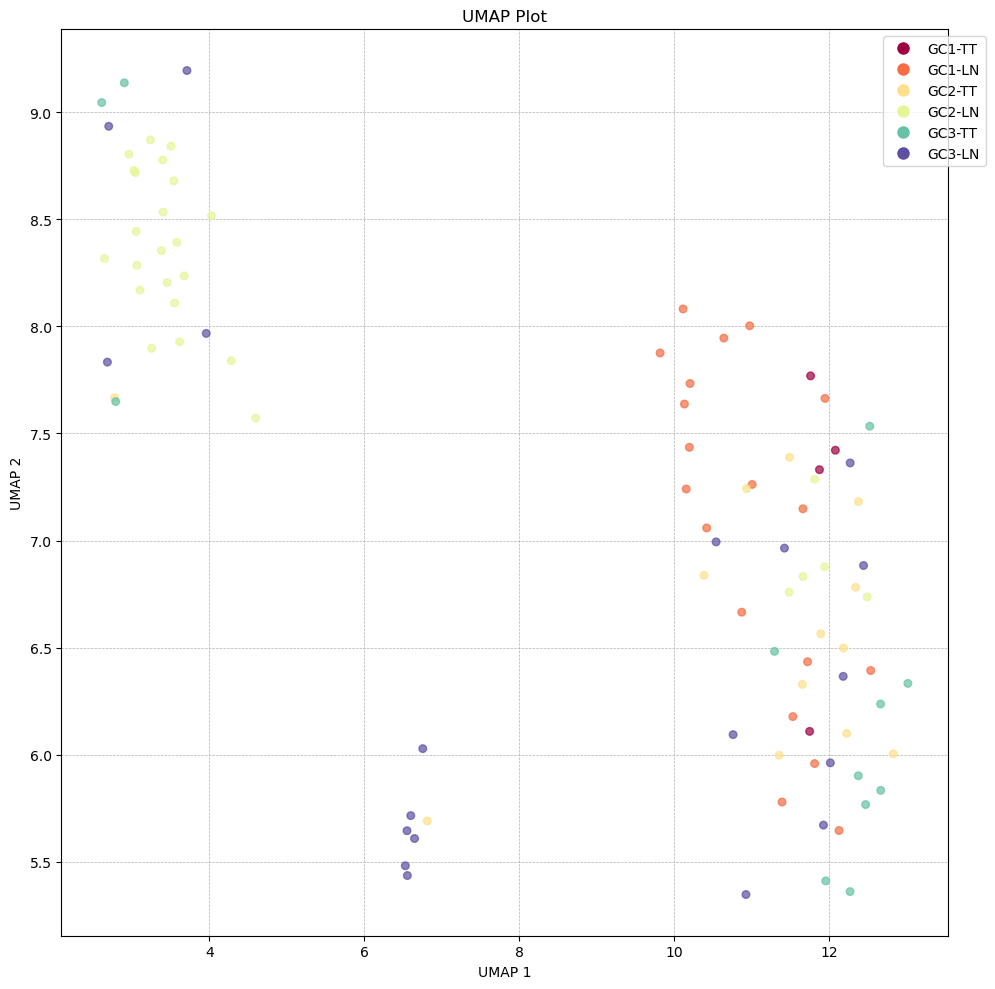

In [74]:
analysis.perform_umap(optimize=False, n_neighbors=5, min_dist=0.04, metric='euclidean', random_state=42) # performing UMAP on the preprocessed dataset
analysis.plot_umap() # plotting the UMAP results

From these results, we can observe that, in 2D, the t-SNE and UMAP visualization show better separability of the data compared to PCA.

# 3. Clustering

In their paper, the authors mention that hierarchical clustering analysis was employed using the `cluster` R function, but they do not specify which specific hierarchical clustering algorithm was used. In our approach, we used 6 different clustering algorithms and separately applied them on each of the 3 reduced datasets, for a total of 18 clustering results. To determine the best performing dimensionality reduction method - clustering algorithm pair, 3 different clustering evaluation metrics were employed. 

The clustering algorithms used are the following:
* __GMM (Gaussian Mixture Model)__:  a probabilistic model that assumes data is generated from a mixture of several Gaussian distributions, each representing a different cluster. It works by iteratively estimating the parameters of these Gaussian distributions using the Expectation-Maximization (EM) algorithm. In scRNA-seq analysis, GMM is useful for identifying distinct cell populations by modeling the gene expression profiles as mixtures of multiple distributions, which helps in capturing the heterogeneity and subpopulations within single-cell data.
* __Average Link__: also known as __UPGMA (Unweighted Pair Group Method with Arithmetic Mean)__, is a hierarchical clustering method that merges clusters based on the average distance between all pairs of data points in the two clusters. It works by iteratively joining the two clusters that have the smallest average pairwise distance until all data points are grouped into a single cluster. This method is useful in scRNA-seq analysis for constructing dendrograms that represent the hierarchical relationships between different cell populations, helping to elucidate the underlying structure and lineage relationships within the data​.
* __Ward' Method__: a hierarchical clustering technique that minimizes the variance within each cluster. It works by iteratively merging the pair of clusters that results in the smallest increase in the total within-cluster variance. In scRNA-seq analysis, Ward's method is useful for producing compact and well-separated clusters, which is critical for accurately identifying and characterizing distinct cell types and states from complex single-cell transcriptomic data​.
* __Spectral clustering__: a technique that uses the eigenvalues of a similarity matrix to perform dimensionality reduction before applying a clustering algorithm. It works by constructing a graph of the data points, computing the Laplacian matrix, and then using its eigenvectors to reduce the dimensionality and reveal the underlying structure of the data. In scRNA-seq analysis, spectral clustering is useful for identifying non-linearly separable clusters and capturing complex relationships between cells, leading to more accurate and meaningful classification of cell types and states​.
* __Louvain algorithm__: a community detection method designed to find clusters in large networks by optimizing modularity, a measure of the strength of division of a network into modules. It works by iteratively grouping nodes into communities based on modularity gain and then aggregating the communities into super-nodes to repeat the process at a higher level. In scRNA-seq analysis, the Louvain algorithm is useful for detecting cell clusters and subpopulations in large and complex datasets, providing insights into the modular organization and functional relationships within the cellular ecosystem​.
* __Leiden algorithm__: an improved version of the Louvain algorithm that guarantees well-connected communities by refining the partitions through multiple iterations. It works by iteratively refining the community structure to ensure that communities are more internally connected and stable. In scRNA-seq analysis, the Leiden algorithm is useful for robustly identifying cell clusters and subpopulations, ensuring that the detected communities are more accurate and reproducible, which is crucial for downstream biological interpretations and analyses​.

The clustering evaluation metrics used are the following:
* __Silhouette Score__: measures how similar an object is to its own cluster compared to other clusters. Values range from -1 to +1. High values (close to +1) indicate that objects are well-matched to their own cluster and poorly matched to neighboring clusters, which suggests good clustering. Low values (close to -1) indicate that objects might be better matched to a neighboring cluster than to their own, suggesting poor clustering. Values around 0 indicate that clusters are overlapping and differentiation between clusters is not clear. The Silhouette Score is useful for assessing the separation and cohesion of the clusters. High values generally indicate a model that has successfully captured the natural structure of the data.
* __Calinski-Harabasz Index__: also known as the __Variance Ratio Criterion__. It measures the ratio of the sum of between-clusters dispersion to within-cluster dispersion. High values indicate that clusters are dense and well-separated, which is characteristic of distinct and well-defined clusters. Low values indicate that clusters are not well-delineated and may be overlapping, suggesting poor clustering. The Calinski-Harabasz Index is particularly useful when the true cluster labels are not known. It relies purely on the dataset features to evaluate the quality of the clustering.
* __Davies-Bouldin Index__: measures the average 'similarity' between clusters, where similarity is a measure that compares the distance between clusters with the size of the clusters themselves. Low values indicate that clusters are well-separated and compact, which generally represents good clustering quality. High values indicate that clusters are either too close to each other or too spread out, suggesting poor clustering. The Davies-Bouldin Index should be minimized, and it provides a quick, intuitive understanding of how well-separated the identified clusters are.

## 3.1. With Optimal Number of Clusters Identification

We begin by defining which clustering algorithms are going to be used.

In [75]:
# Defining the clustering methods
methods = ['gmm', 'average_link', 'ward', 'spectral', 'louvain', 'leiden']

We then perform clustering with these algorithms, separately on each of the reduced datasets, by using the `cluster_and_evaluate` method, which utilizes the `apply_clustering` and `evaluate_clustering` methods, which apply clustering to the given data using the specified methods and evaluates the clustering of the given data using the produced cluster labels respectively. 

The `cluster_and_evaluate` method also offers optimal number of clusters identification capabilities, with the `optimize=True` argument, where instead of the user providing the number of clusters as an input, the pipeline determines it by trying a variety of different numbers of clusters and keeping the clustering result with the highest Silhouette score. This is only relevant for the GMM, average link, Ward and spectral clustering algorithms, since Louvain and Leiden graph-based algorithms do not take the number of clusters as input anyway. We employ this cluster number optimization approach at this stage of our analysis.

We begin by running `cluster_and_evaluate` on our PCA-reduced dataset.

Clustering and evaluating PCA results...
Clustering with gmm...
Using X_pca embeddings...
Best number of clusters for gmm: 2 with silhouette score: 0.035762857645750046


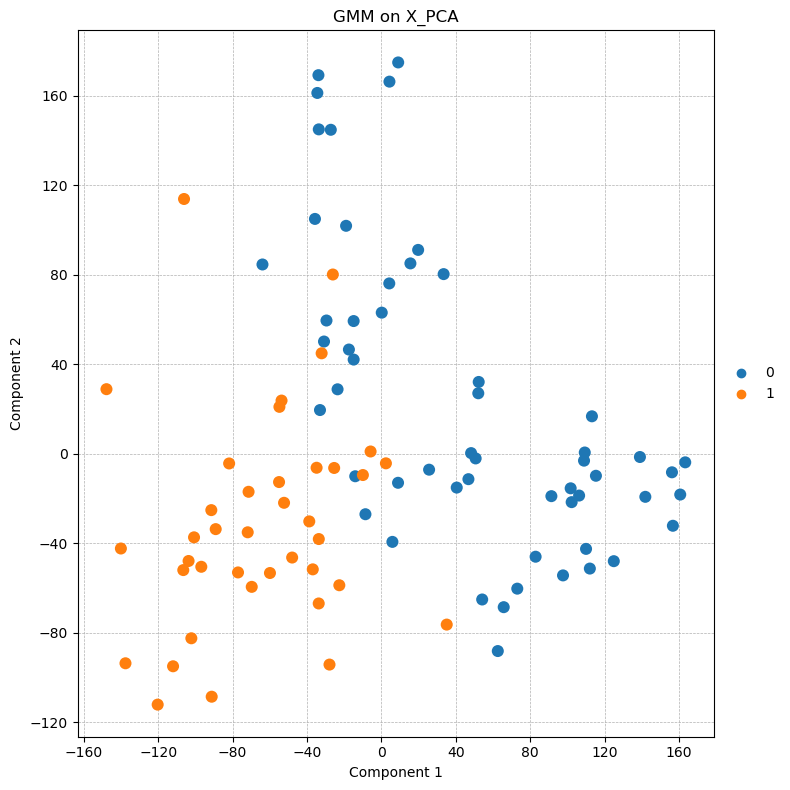

Clustering with average_link...
Using X_pca embeddings...
Best number of clusters for average_link: 2 with silhouette score: 0.06570962816476822


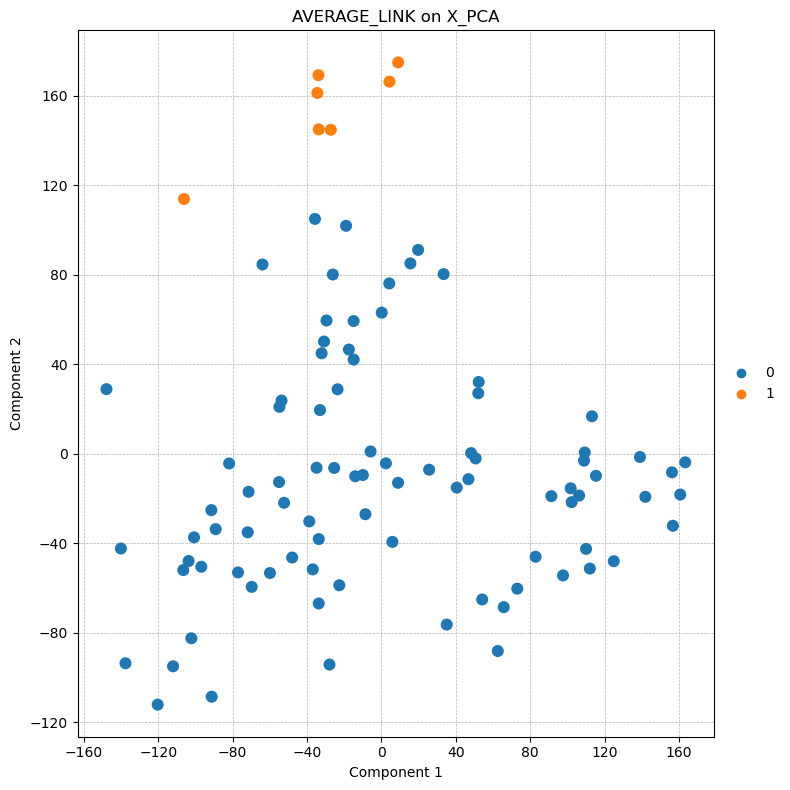

Clustering with ward...
Using X_pca embeddings...
Best number of clusters for ward: 5 with silhouette score: 0.02302495390176773


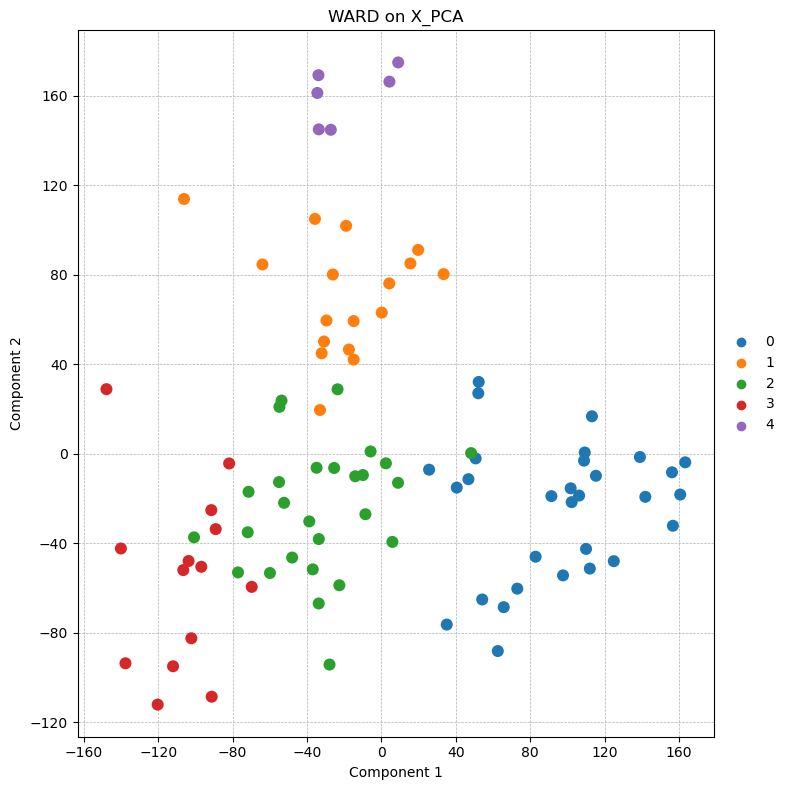

Clustering with spectral...
Using X_pca embeddings...
Best number of clusters for spectral: 2 with silhouette score: 0.03244286775588989


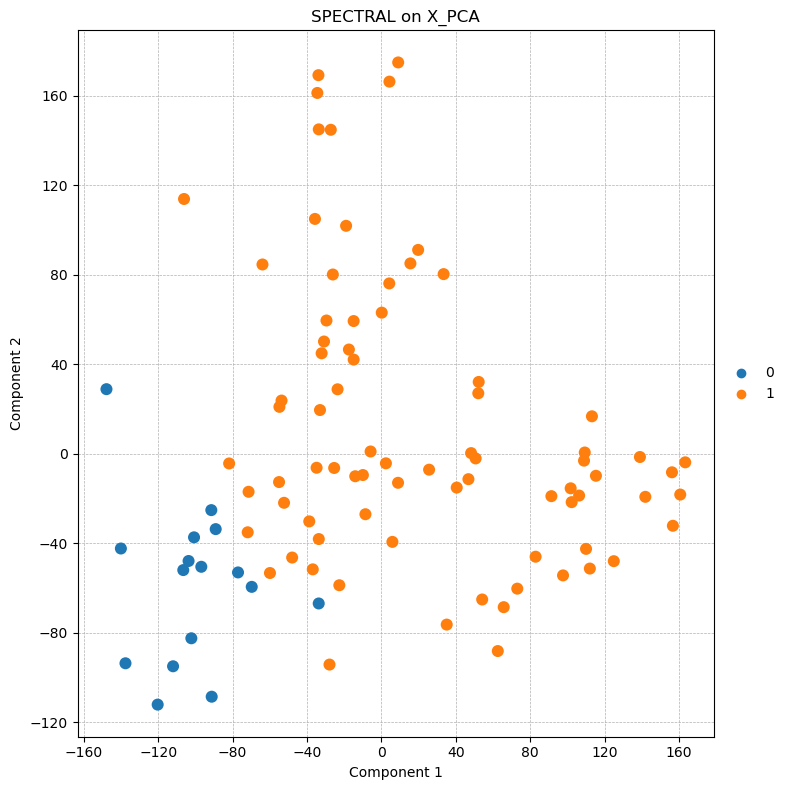

Clustering with louvain...
Using X_pca embeddings...


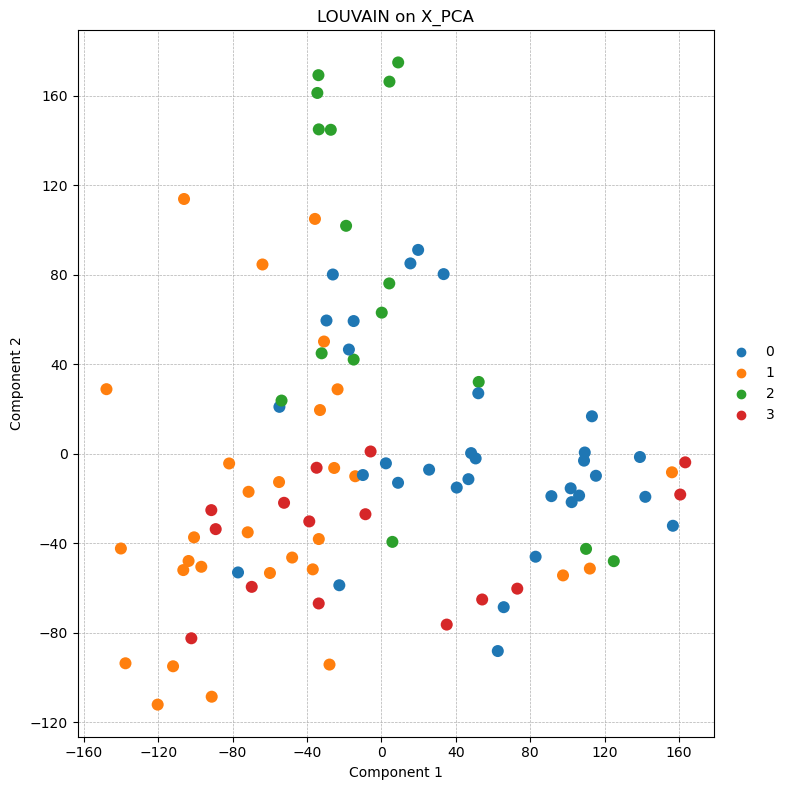

Clustering with leiden...
Using X_pca embeddings...


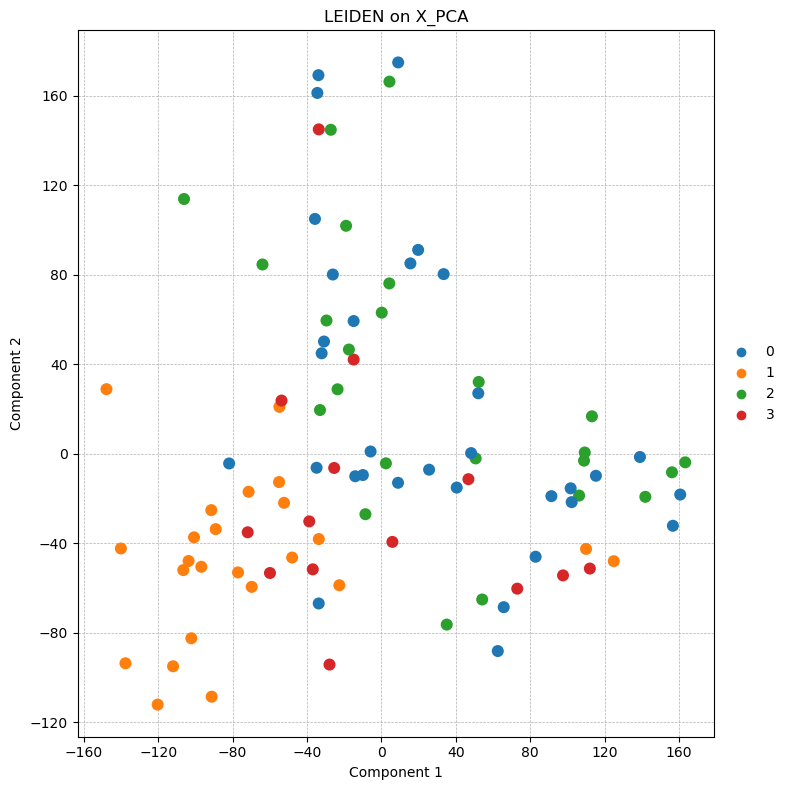

In [76]:
# Performing clustering and evaluation on PCA data with optimal number of clusters identification
print("Clustering and evaluating PCA results...")
results_pca = analysis.cluster_and_evaluate(methods, embeddings=['X_pca'], optimize=True)

We then move on to the t-SNE-reduced data.

Clustering and evaluating t-SNE results...
Clustering with gmm...
Using X_tsne embeddings...
Best number of clusters for gmm: 2 with silhouette score: 0.6358813643455505


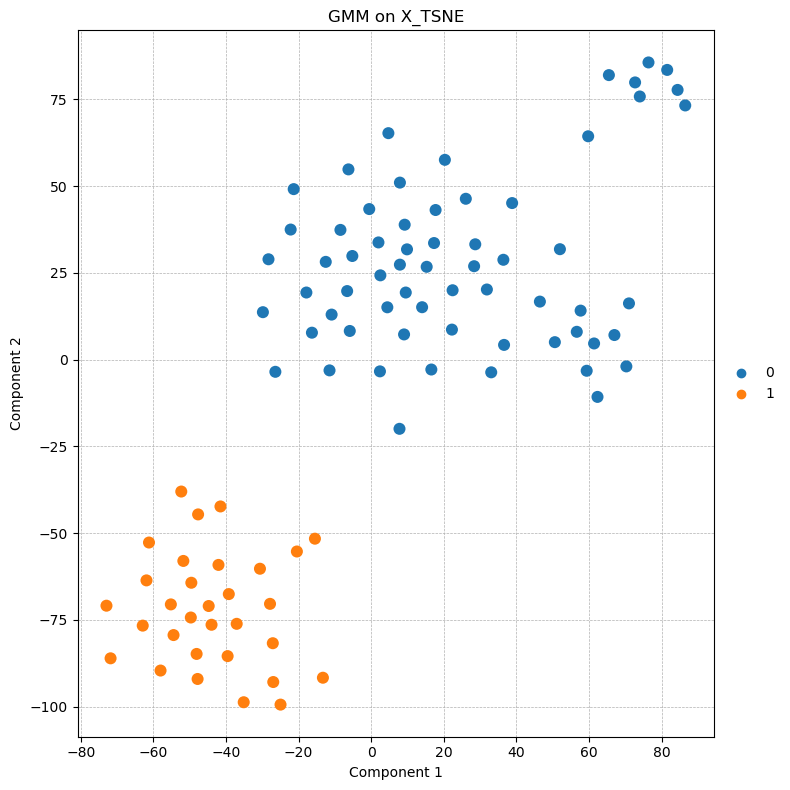

Clustering with average_link...
Using X_tsne embeddings...
Best number of clusters for average_link: 2 with silhouette score: 0.6358813643455505


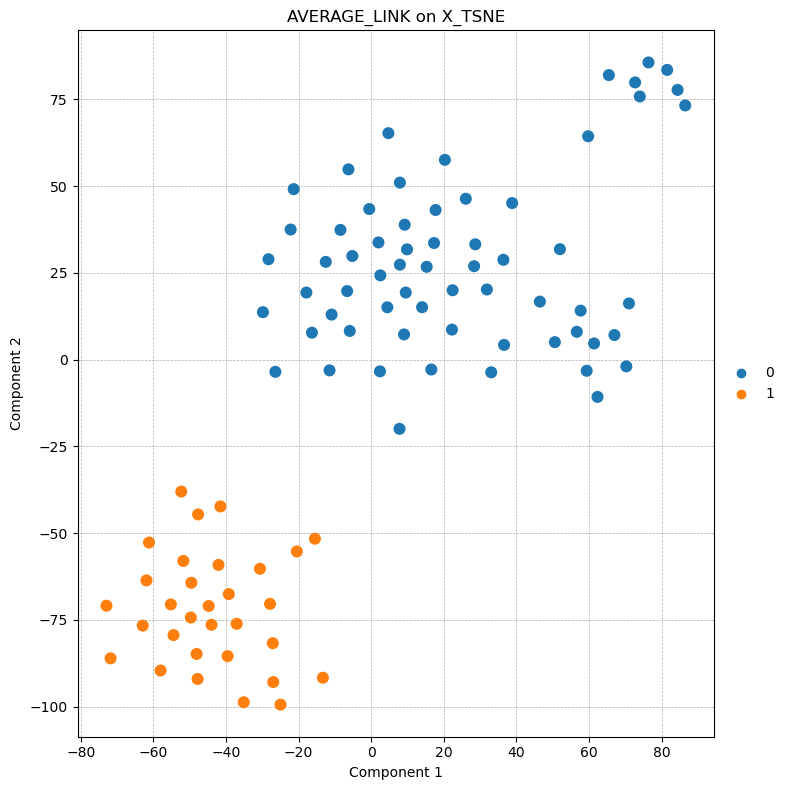

Clustering with ward...
Using X_tsne embeddings...
Best number of clusters for ward: 2 with silhouette score: 0.6358813643455505


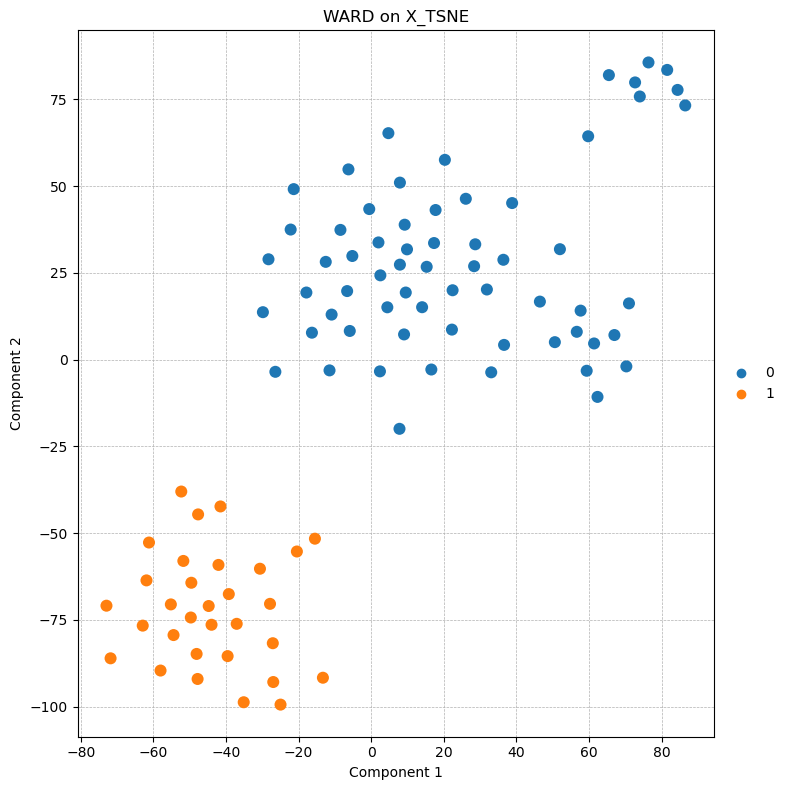

Clustering with spectral...
Using X_tsne embeddings...
Best number of clusters for spectral: 2 with silhouette score: 0.6358813643455505


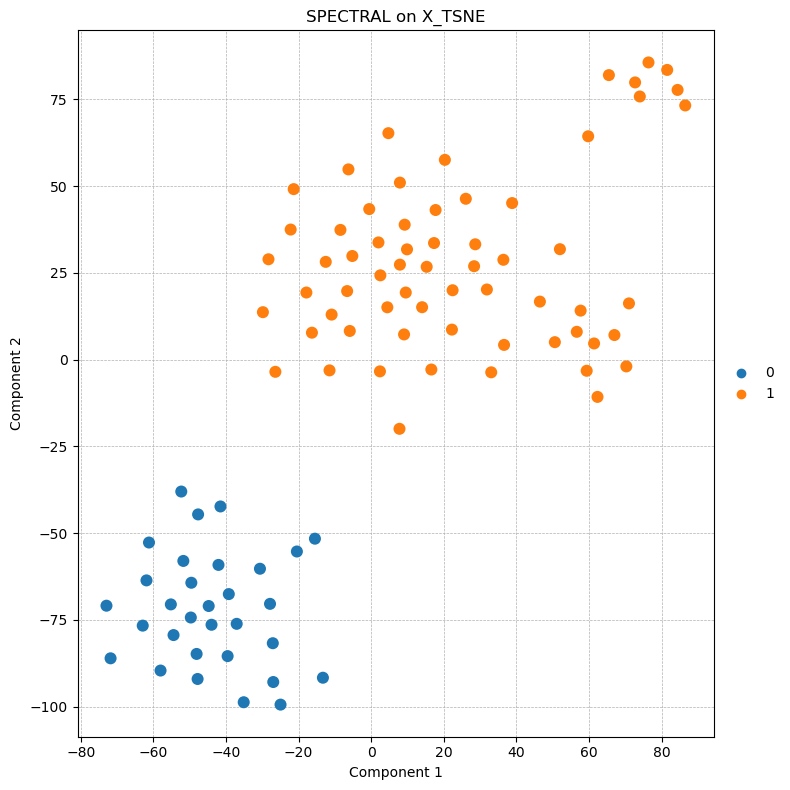

Clustering with louvain...
Using X_tsne embeddings...


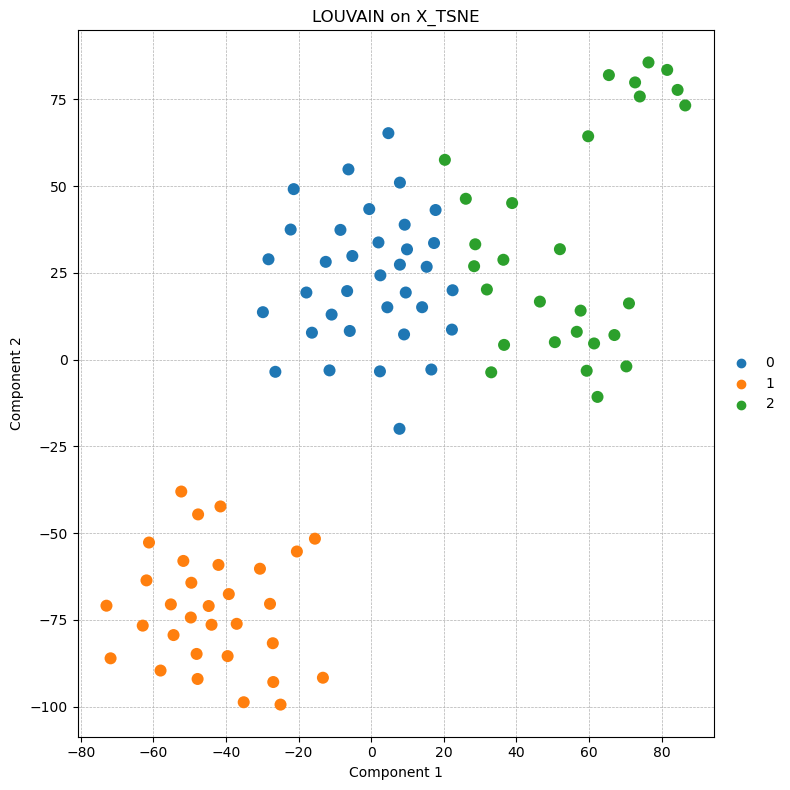

Clustering with leiden...
Using X_tsne embeddings...


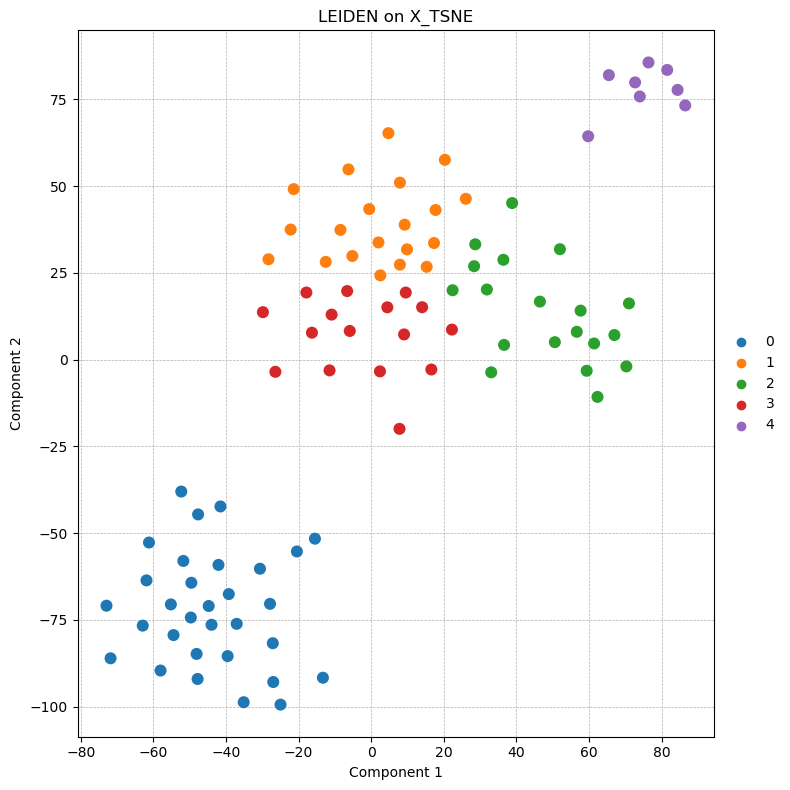

In [77]:
# Performing clustering and evaluation on t-SNE data with optimal number of clusters identification
print("Clustering and evaluating t-SNE results...")
results_tsne = analysis.cluster_and_evaluate(methods, embeddings=['X_tsne'], optimize=True)

Finally, we run `cluster_and_evaluate` for the UMAP-reduced dataset.

Clustering and evaluating UMAP results...
Clustering with gmm...
Using X_umap embeddings...
Best number of clusters for gmm: 2 with silhouette score: 0.7812650203704834


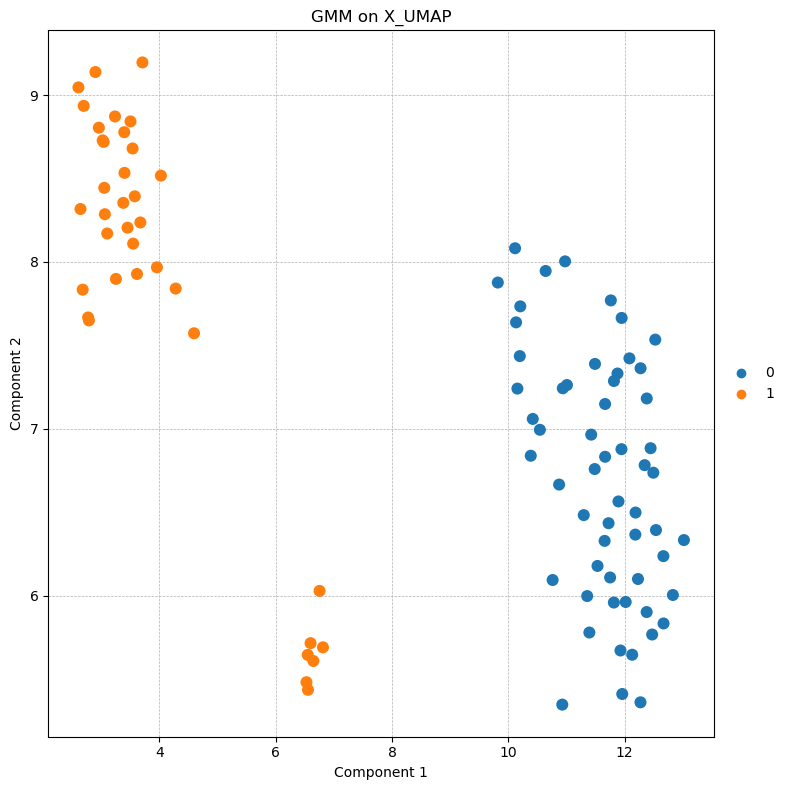

Clustering with average_link...
Using X_umap embeddings...
Best number of clusters for average_link: 2 with silhouette score: 0.7812650203704834


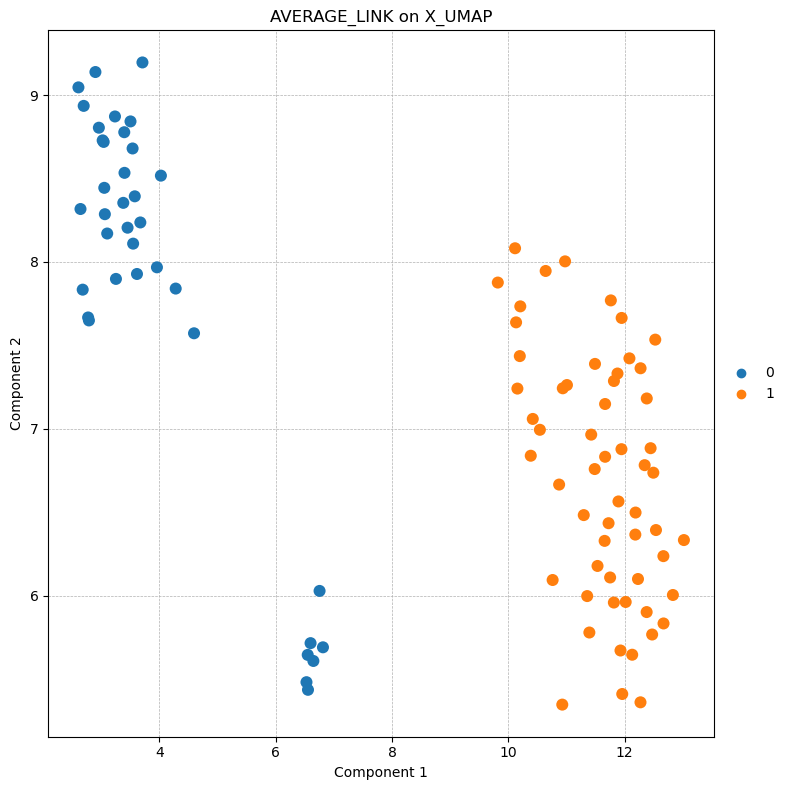

Clustering with ward...
Using X_umap embeddings...
Best number of clusters for ward: 2 with silhouette score: 0.7812650203704834


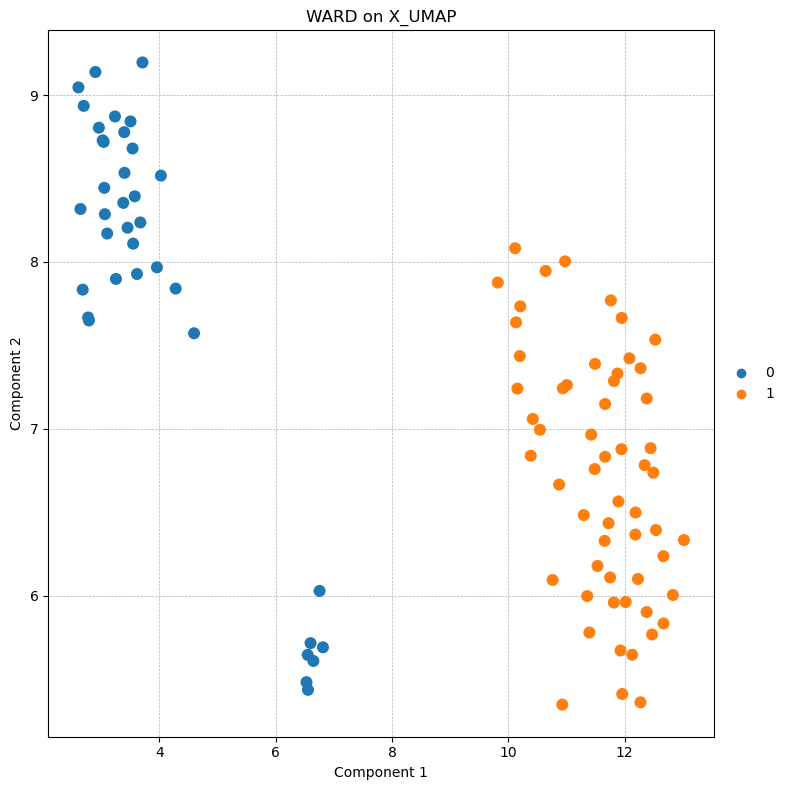

Clustering with spectral...
Using X_umap embeddings...
Best number of clusters for spectral: 2 with silhouette score: 0.7812650203704834


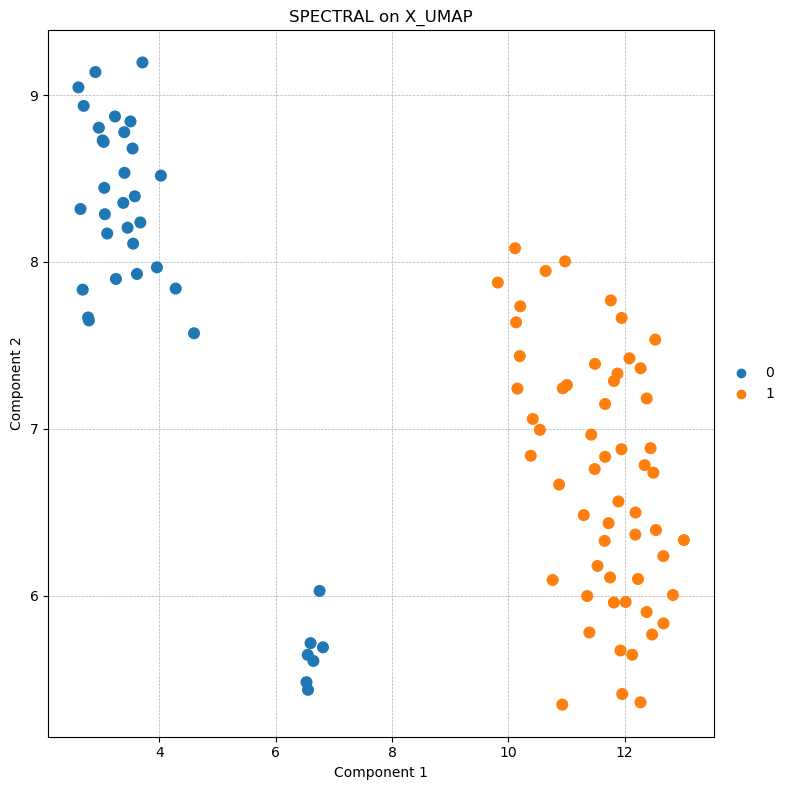

Clustering with louvain...
Using X_umap embeddings...


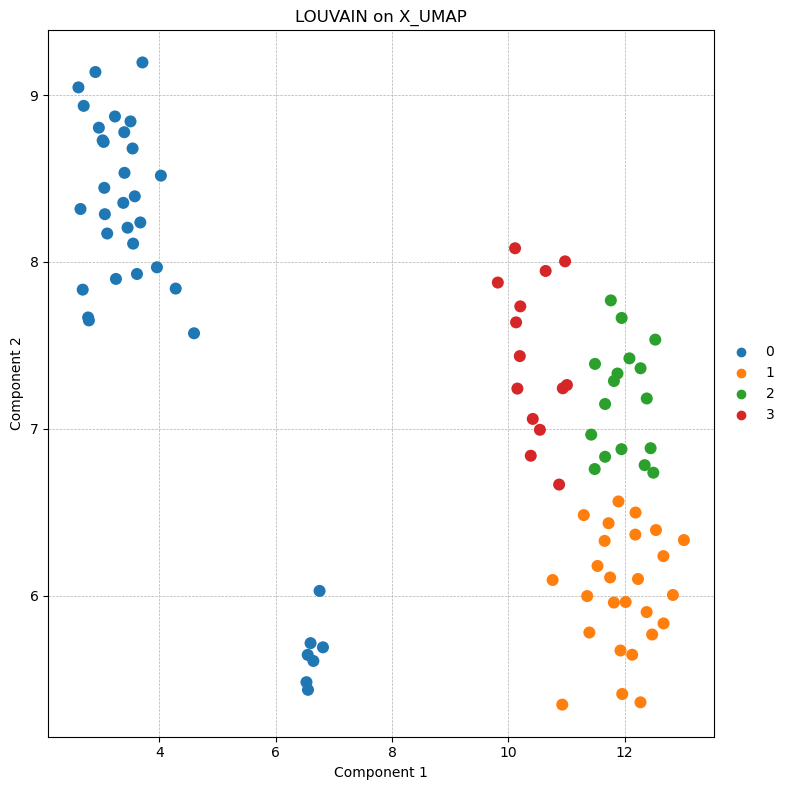

Clustering with leiden...
Using X_umap embeddings...


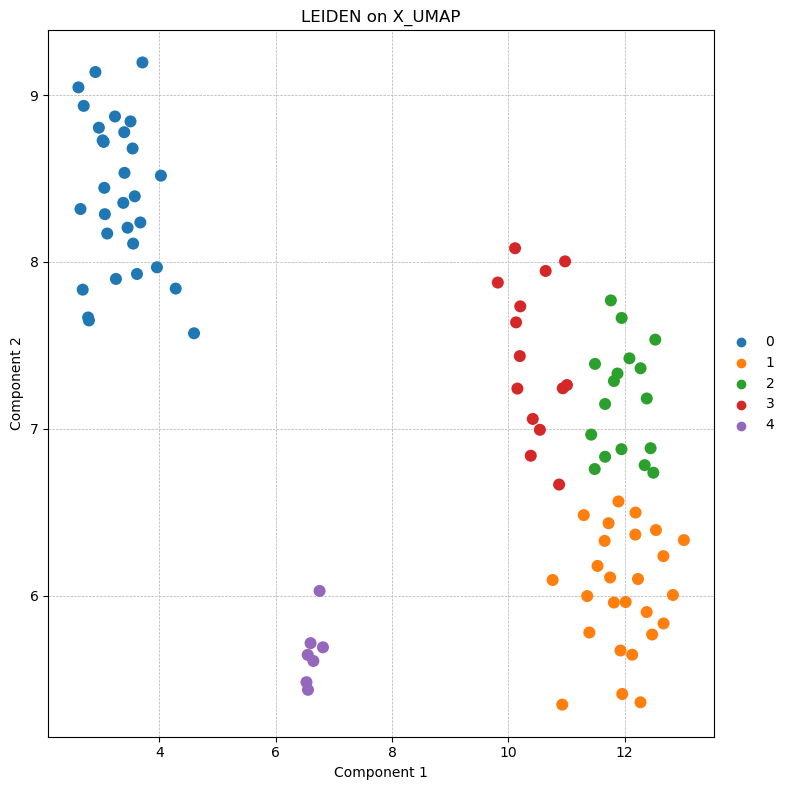

In [78]:
# Performing clustering and evaluation on UMAP data with optimal number of clusters identification
print("Clustering and evaluating UMAP results...")
results_umap = analysis.cluster_and_evaluate(methods, embeddings=['X_umap'], optimize=True)

We then combine all of the clustering results and put them in a dataframe using the `create_results_dataframe` method.

In [79]:
# Combining all clustering results
combined_results = {
    'PCA': results_pca,
    't-SNE': results_tsne,
    'UMAP': results_umap
}

# Creating a DataFrame for results
results_df = analysis.create_results_dataframe(combined_results)

# Displaying the results
display(results_df)

Embedding Clustering Algorithm  Silhouette Score  Calinski-Harabasz Index  \
0      X_pca                  gmm             0.036                    3.504   
1      X_pca         average_link             0.066                    2.277   
2      X_pca                 ward             0.023                    2.549   
3      X_pca             spectral             0.032                    2.849   
4      X_pca              louvain            -0.004                    1.643   
5      X_pca               leiden             0.003                    1.697   
6     X_tsne                  gmm             0.636                  227.365   
7     X_tsne         average_link             0.636                  227.365   
8     X_tsne                 ward             0.636                  227.365   
9     X_tsne             spectral             0.636                  227.365   
10    X_tsne              louvain             0.506                  221.066   
11    X_tsne               leiden             0.499                  235.402   
12    X_umap                  gmm             0.781                  667.831   
13    X_umap         average_link             0.781                  667.831   
14    X_umap                 ward             0.781                  667.831   
15    X_umap             spectral             0.781                  667.831   
16    X_umap              louvain             0.513                  302.887   
17    X_umap               leiden             0.574                 1002.308   

    Davies-Bouldin Score  
0                  5.021  
1                  3.291  
2                  4.530  
3                  4.177  
4                  5.462  
5                  5.890  
6                  0.468  
7                  0.468  
8                  0.468  
9                  0.468  
10                 0.790  
11                 0.727  
12                 0.314  
13                 0.314  
14                 0.314  
15                 0.314  
16                 0.696  
17                 0.567

Finally, we plot the clustering evaluation results, using the `plot_clustering_evaluation` method, in order to visualize and interpret them.

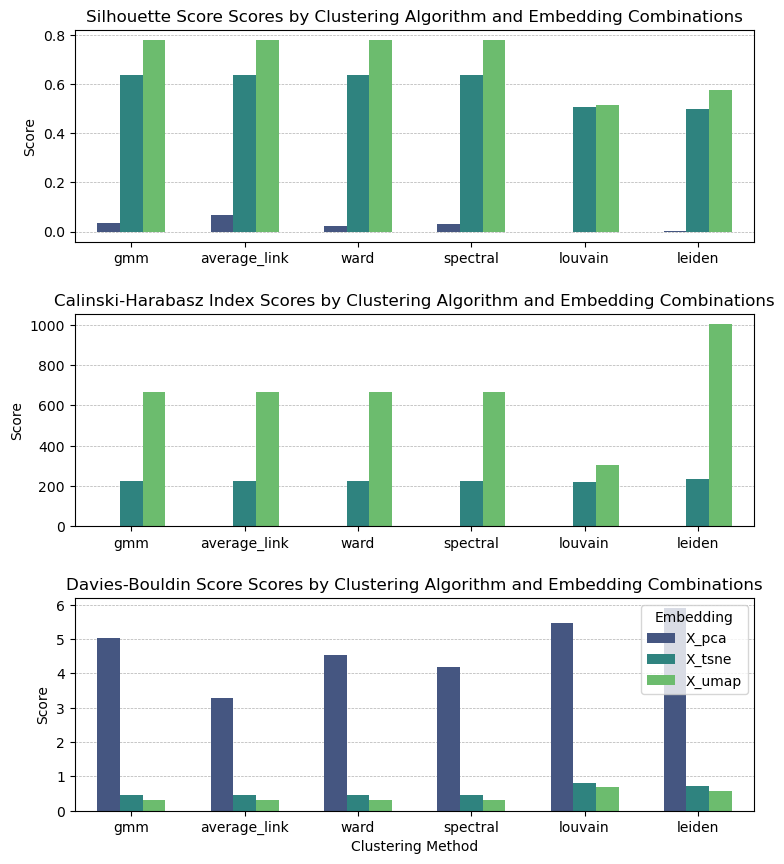

In [80]:
# Plotting the clustering evaluation results
analysis.plot_clustering_evaluation(results_df)

The best clustering result is achieved using UMAP with GMM, Average Linkage, Ward, or Spectral Clustering. This combination yields the highest Silhouette Score (0.781) and the lowest Davies-Bouldin Score (0.314), indicating the clusters are well-defined, compact, and well-separated. The high Calinski-Harabasz Index (667.831) further supports the quality of these clusters.

It is important to note that by optimizing the number of clusters for the algorithms, we can observe that, in most cases, the number of clusters is different that 4, which is the number of clusters the authors have in their paper. We comment on this further in our project report.

## 3.2. Without Optimal Number of Clusters Identification

In order to more directly compare our results with the authors' results, we decided to use 4 clusters as input to run the clustering, instead of optimizing the number of clusters (running `cluster_and_evaluate` with the `optimize=False` argument). We then follow the exact same pipeline to get our clustering evaluation results.

Clustering and evaluating PCA results...
Clustering with gmm...
Using X_pca embeddings...


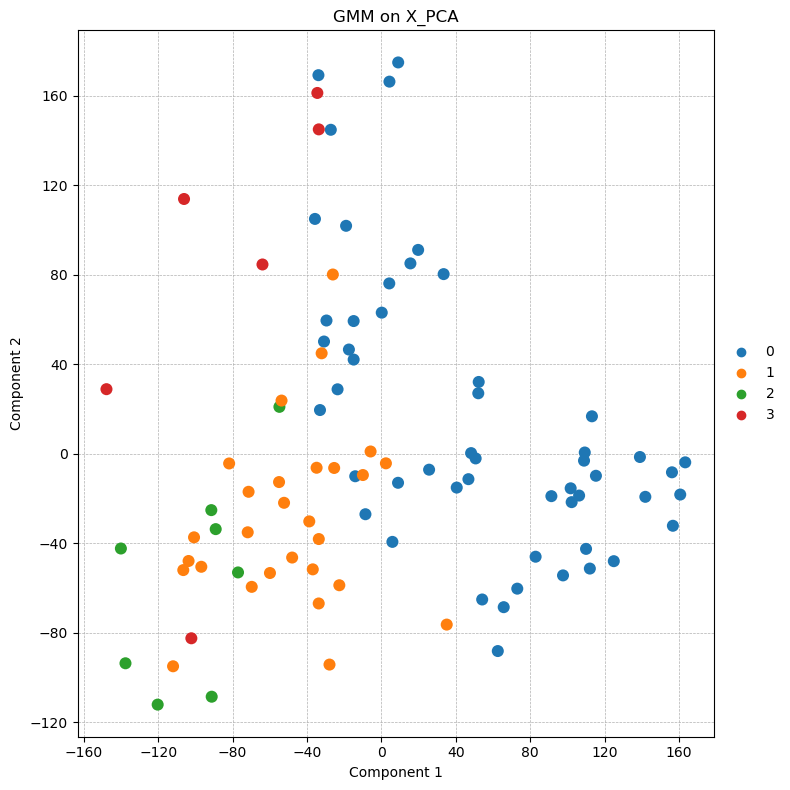

Clustering with average_link...
Using X_pca embeddings...


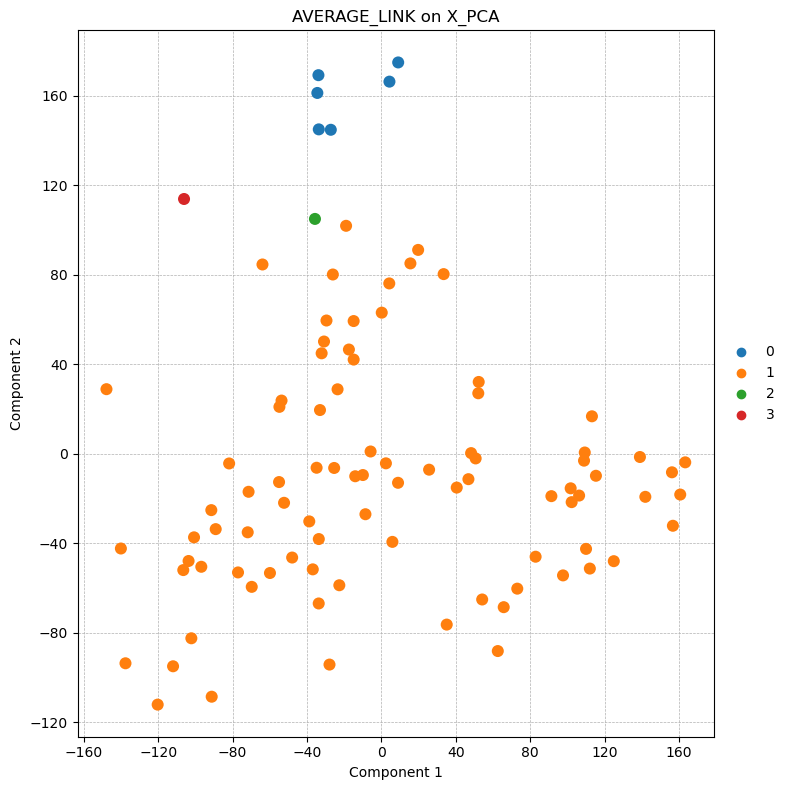

Clustering with ward...
Using X_pca embeddings...


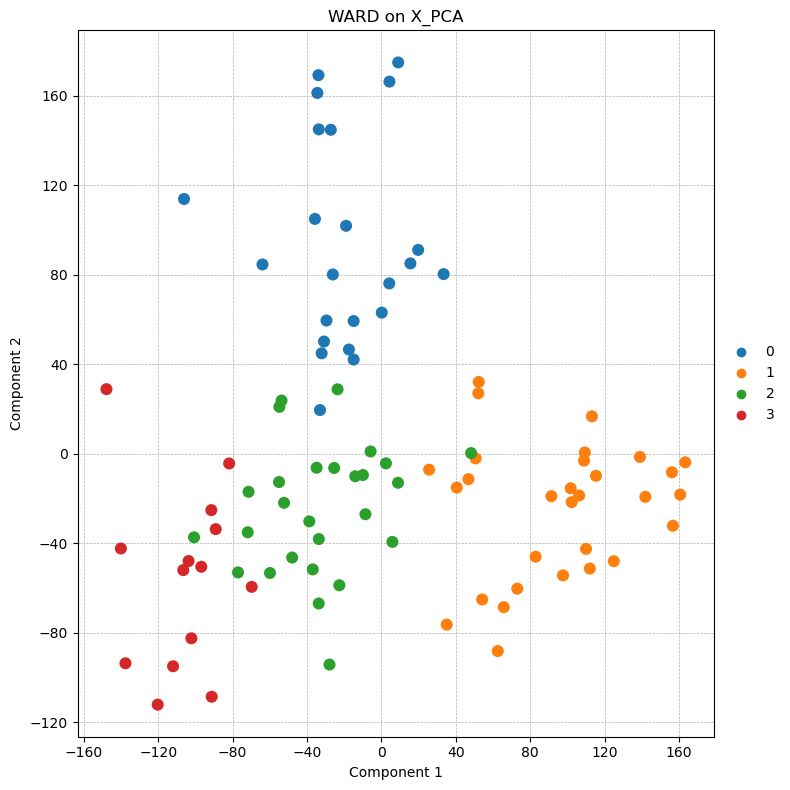

Clustering with spectral...
Using X_pca embeddings...


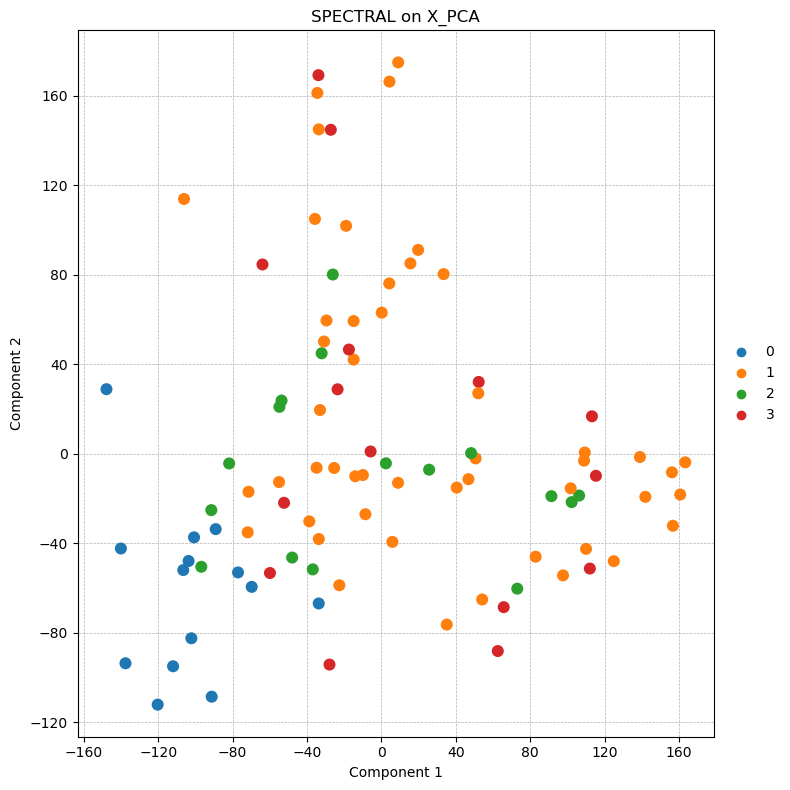

Clustering with louvain...
Using X_pca embeddings...


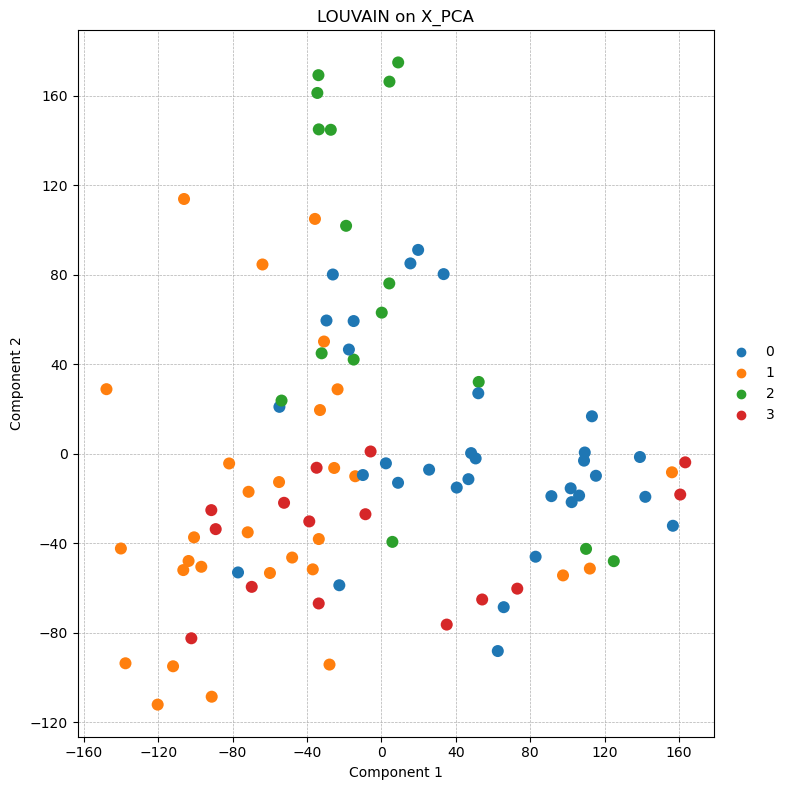

Clustering with leiden...
Using X_pca embeddings...


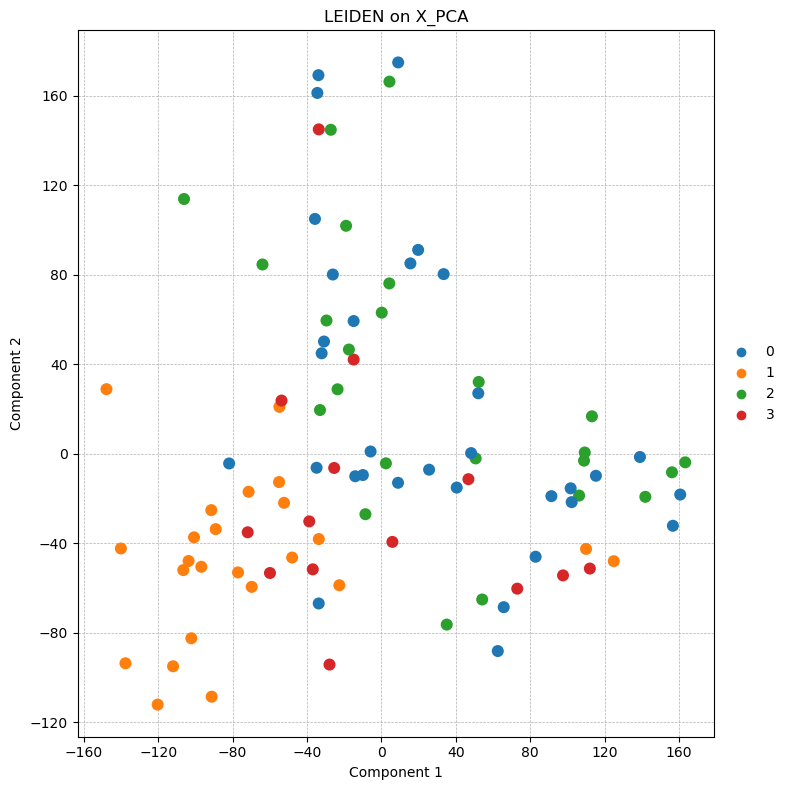

In [81]:
# Performing clustering and evaluation on PCA data without optimization (using the default 4 clusters)
print("Clustering and evaluating PCA results...")
results_pca = analysis.cluster_and_evaluate(methods, embeddings=['X_pca'], optimize=False, n_clusters=4)

Clustering and evaluating t-SNE results...
Clustering with gmm...
Using X_tsne embeddings...


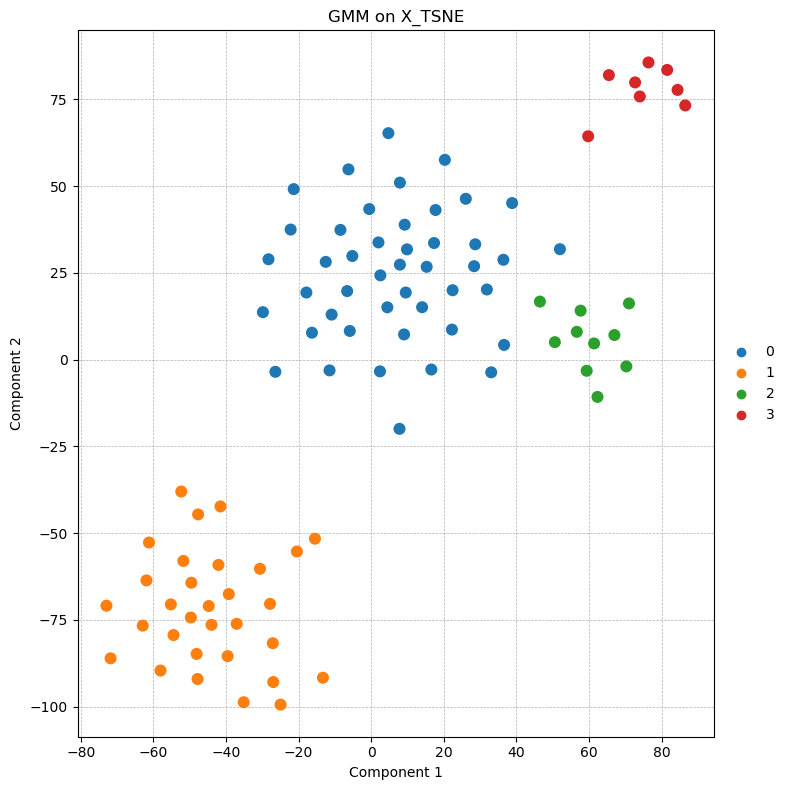

Clustering with average_link...
Using X_tsne embeddings...


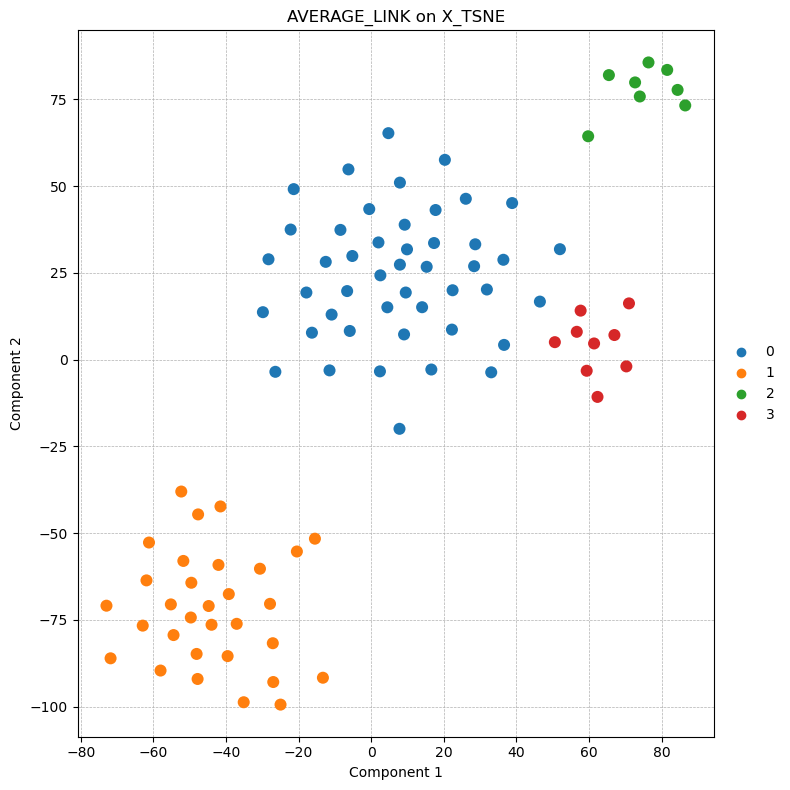

Clustering with ward...
Using X_tsne embeddings...


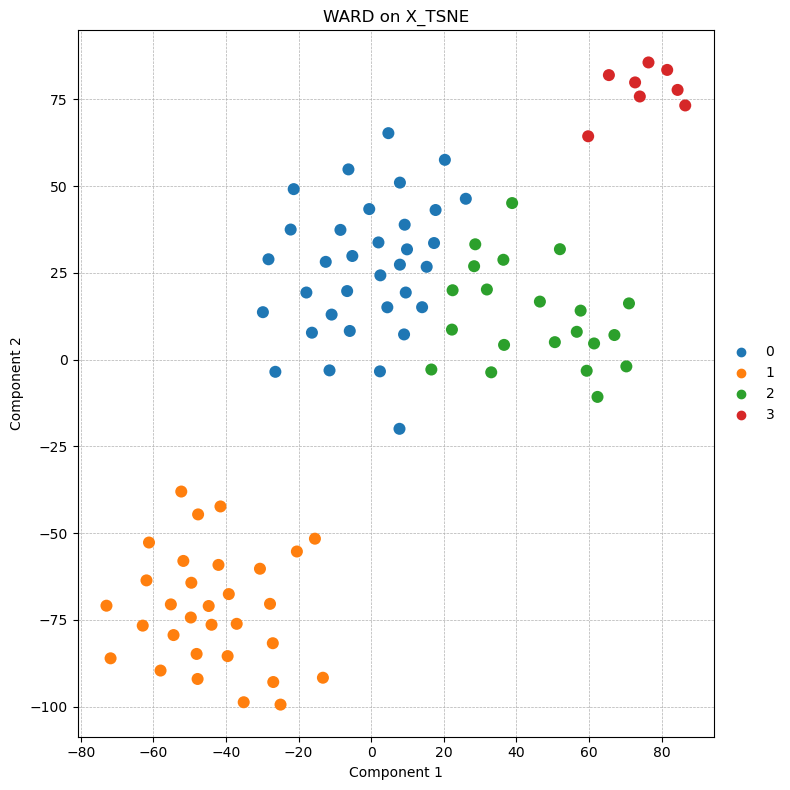

Clustering with spectral...
Using X_tsne embeddings...


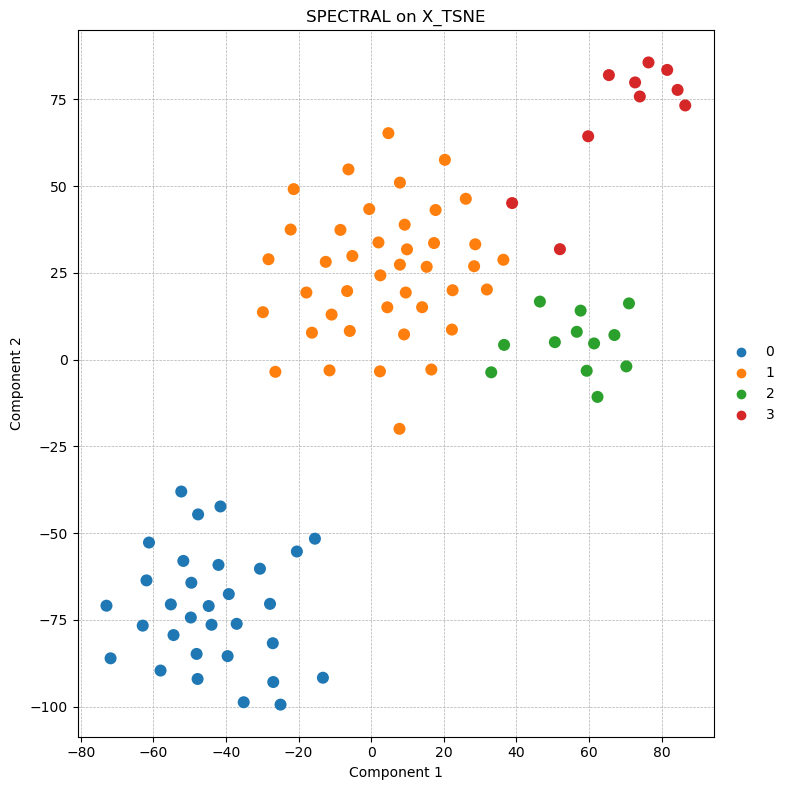

Clustering with louvain...
Using X_tsne embeddings...


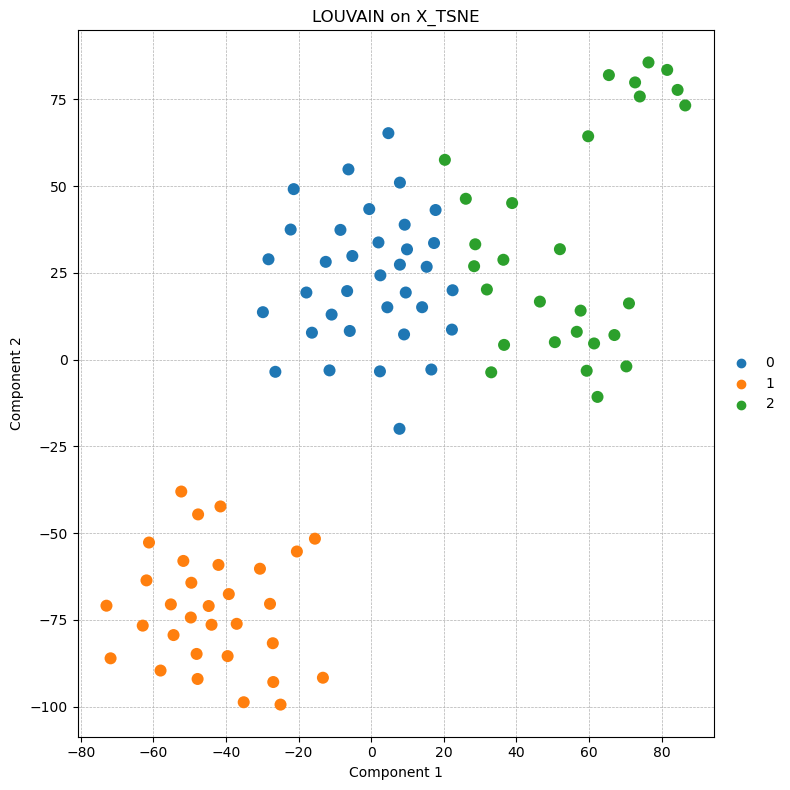

Clustering with leiden...
Using X_tsne embeddings...


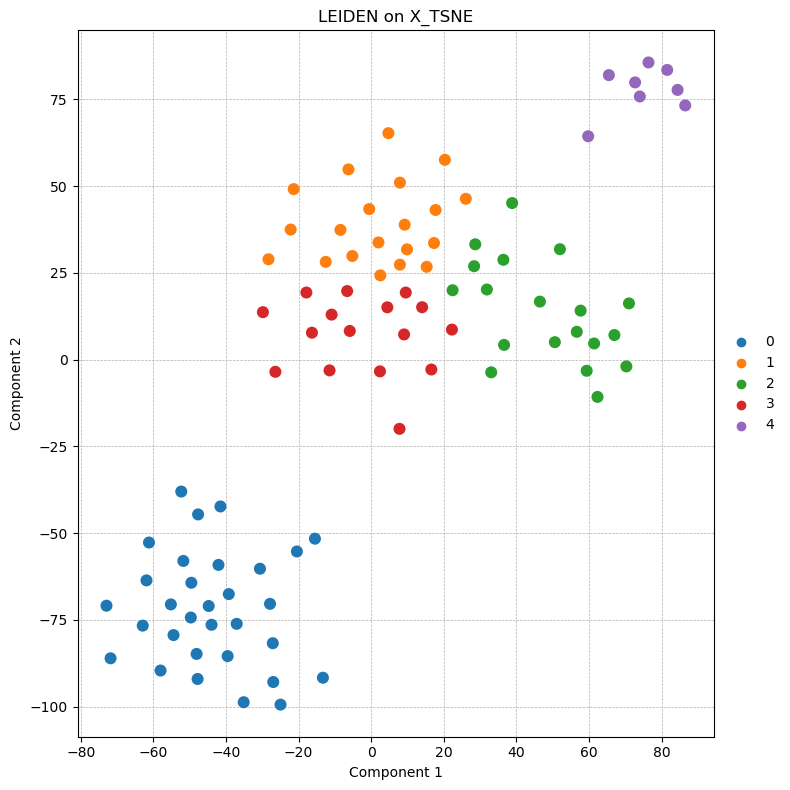

In [82]:
# Performing clustering and evaluation on t-SNE data without optimization (using the default 4 clusters)
print("Clustering and evaluating t-SNE results...")
results_tsne = analysis.cluster_and_evaluate(methods, embeddings=['X_tsne'], optimize=False, n_clusters=4)

Clustering and evaluating UMAP results...
Clustering with gmm...
Using X_umap embeddings...


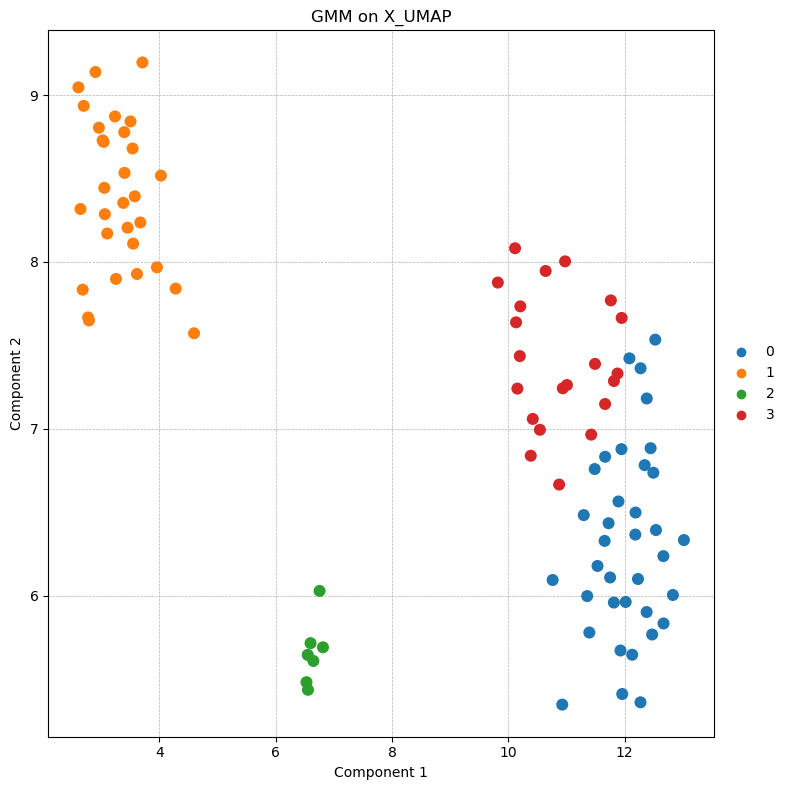

Clustering with average_link...
Using X_umap embeddings...


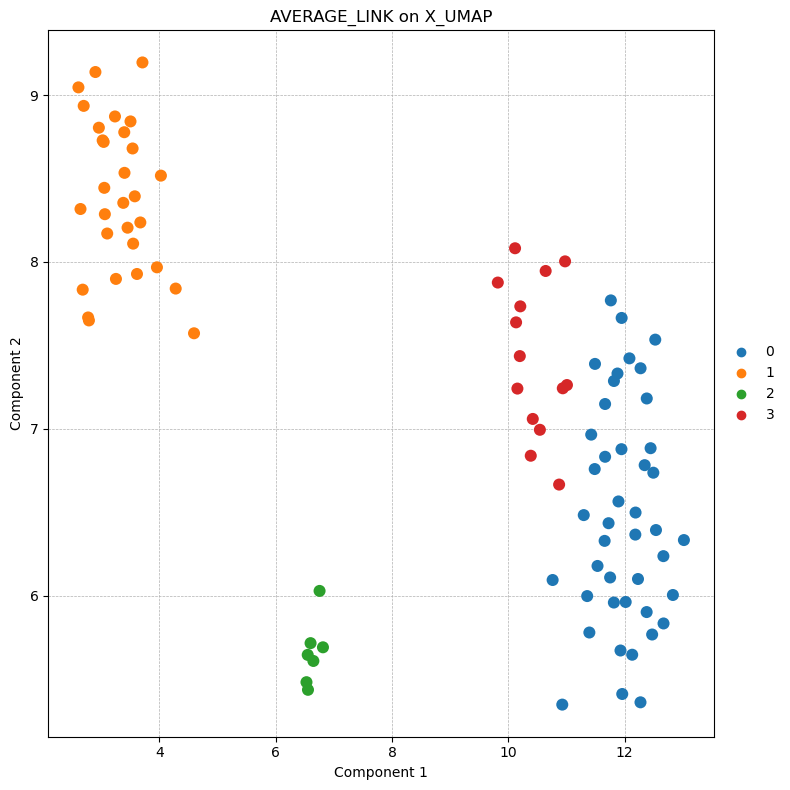

Clustering with ward...
Using X_umap embeddings...


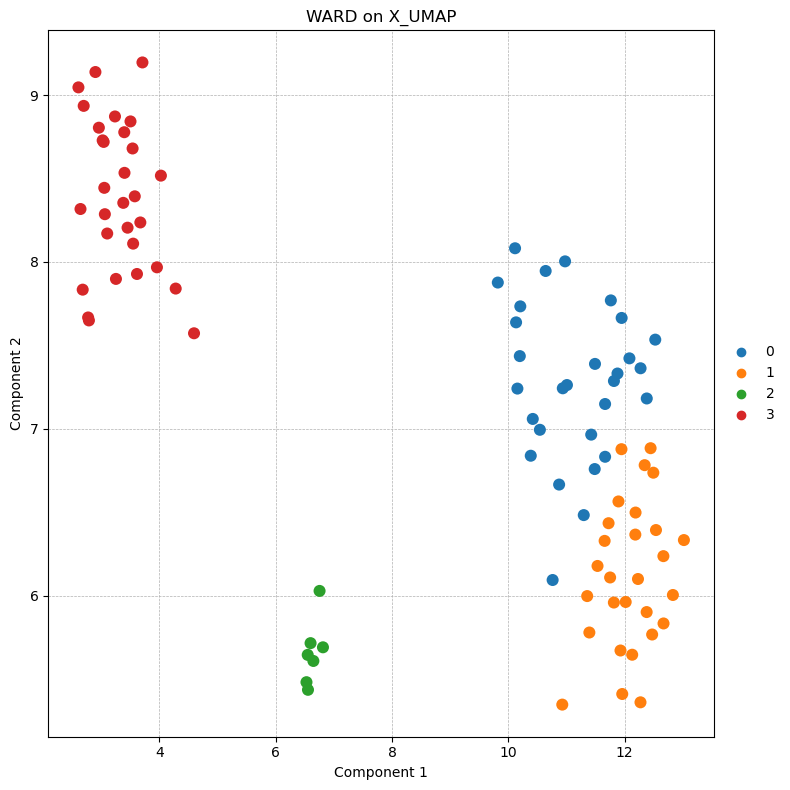

Clustering with spectral...
Using X_umap embeddings...


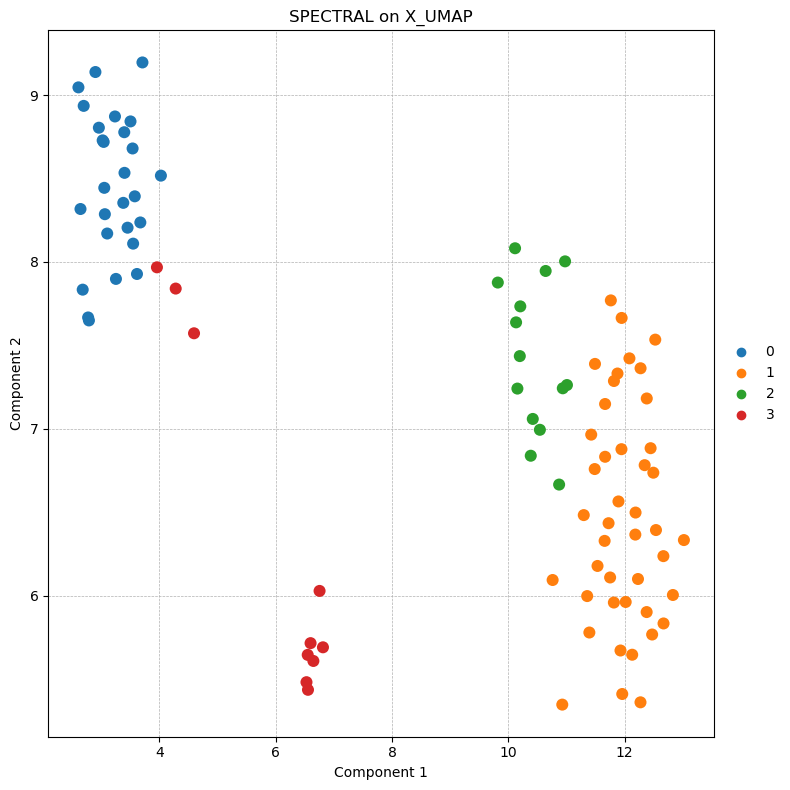

Clustering with louvain...
Using X_umap embeddings...


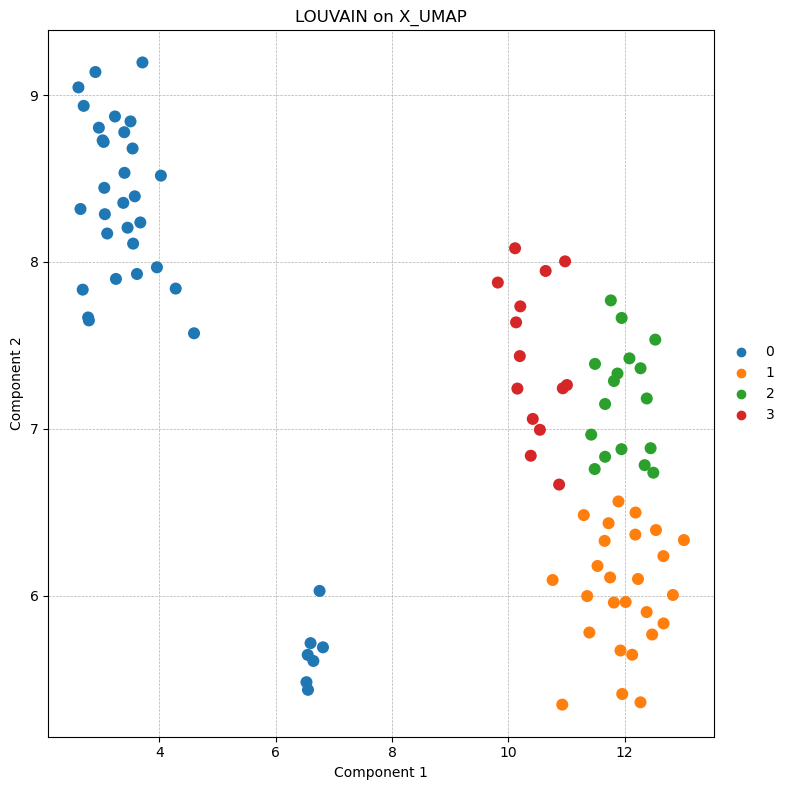

Clustering with leiden...
Using X_umap embeddings...


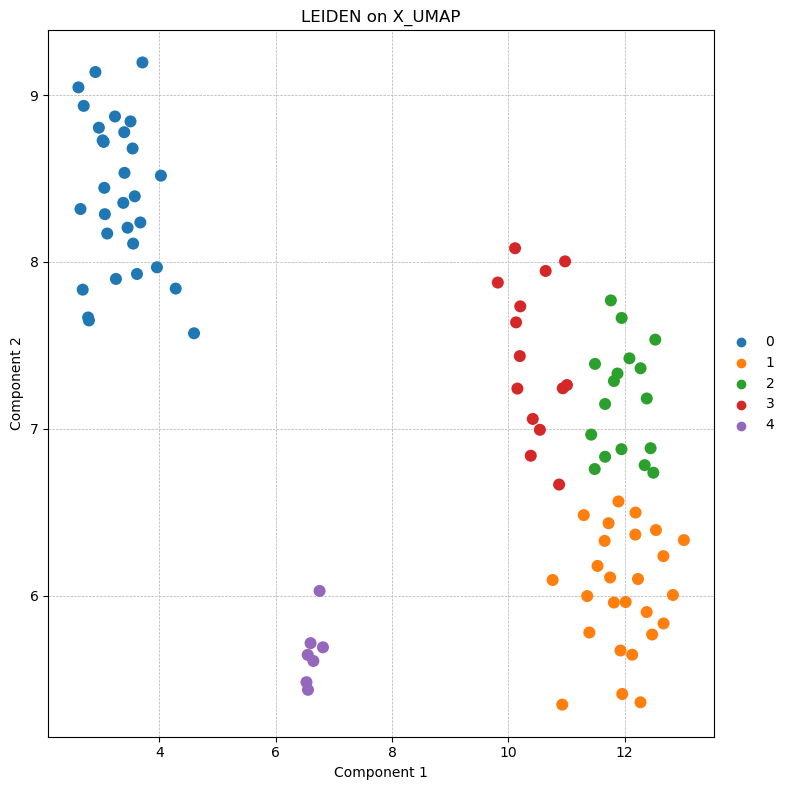

In [83]:
# Performing clustering and evaluation on UMAP data without optimization (using the default 4 clusters)
print("Clustering and evaluating UMAP results...")
results_umap = analysis.cluster_and_evaluate(methods, embeddings=['X_umap'], optimize=False, n_clusters=4)

In [84]:
# Combining all clustering results
combined_results = {
    'PCA': results_pca,
    't-SNE': results_tsne,
    'UMAP': results_umap
}

# Creating a DataFrame for results
results_df = analysis.create_results_dataframe(combined_results)

# Displaying the results
display(results_df)

Embedding Clustering Algorithm  Silhouette Score  Calinski-Harabasz Index  \
0      X_pca                  gmm             0.024                    2.047   
1      X_pca         average_link             0.054                    1.569   
2      X_pca                 ward             0.022                    2.903   
3      X_pca             spectral             0.007                    1.611   
4      X_pca              louvain            -0.004                    1.643   
5      X_pca               leiden             0.003                    1.697   
6     X_tsne                  gmm             0.564                  225.167   
7     X_tsne         average_link             0.561                  218.945   
8     X_tsne                 ward             0.550                  247.511   
9     X_tsne             spectral             0.561                  233.384   
10    X_tsne              louvain             0.506                  221.066   
11    X_tsne               leiden             0.499                  235.402   
12    X_umap                  gmm             0.576                  949.793   
13    X_umap         average_link             0.607                  954.279   
14    X_umap                 ward             0.563                  922.370   
15    X_umap             spectral             0.547                  691.895   
16    X_umap              louvain             0.513                  302.887   
17    X_umap               leiden             0.574                 1002.308   

    Davies-Bouldin Score  
0                  4.604  
1                  1.976  
2                  4.697  
3                  5.813  
4                  5.462  
5                  5.890  
6                  0.503  
7                  0.495  
8                  0.638  
9                  0.547  
10                 0.790  
11                 0.727  
12                 0.540  
13                 0.448  
14                 0.568  
15                 0.629  
16                 0.696  
17                 0.567

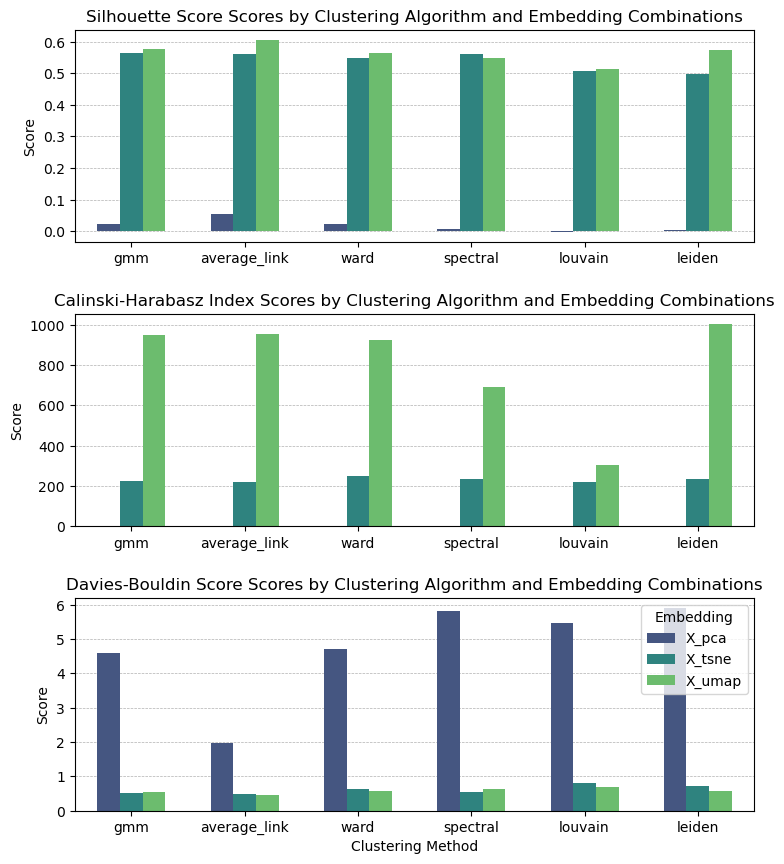

In [85]:
# Plotting the clustering evaluation results
analysis.plot_clustering_evaluation(results_df)

Given these metrics, the best clustering result is achieved using UMAP with Average Linkage Clustering because it has the highest Silhouette Score (0.607), the second highest Calinski-Harabasz Index (954.279, second only to Leiden on UMAP), and the lowest Davies-Bouldin Score (0.448), indicating well-separated and compact clusters.

It is important to note that our best clustering combination with 4 clustes was UMAP with Average Linkage Clustering, while the authors' result present a combination of PCA and t-SNE and unspecified Hierarcical clustering. We comment on this further in our project report.

# 4. Post-Clusterig Analysis

## 4.1. Marker Gene Identification

Marker genes are identified based on their differential expression between different groups or conditions. They are the genes that show significant differences in expression levels between specific cell types, tissues, or experimental conditions, rather than just having high overall expression. Marker genes help distinguish one group from another, providing insights into the biological characteristics and functional roles of the groups being compared. The identification process involves statistical methods to ensure the differences are significant and not due to random variation.

In our implementation, we use the `analyze_and_plot_markers` method in order to identify the top 10 highly expressed marker genes of each cluster from our best clustering results (UMAP with Average Linkage clustering) and plot them in a heatmap (rows = genes, columns = cells, coloured bars in x-axis = clusters), similarly to what the authors did in their paper, in order to compare the similarity of our results to theirs (the amount of overlap in marker genes).

Marker genes saved to ../data/marker_genes.csv
Top marker genes for each cluster:

Cluster 0:
1. HBA2
2. HBA1
3. HBB
4. RAB12
5. MTRNR2L8
6. NOMO3
7. NOMO1
8. MTRNR2L1
9. REXO1L1
10. MTRNR2L2

Cluster 1:
1. FZD3
2. ARL4A
3. ING3
4. ZBTB41
5. MON2
6. IPO11
7. SNX13
8. EXOC5
9. BNC2
10. PTPRJ

Cluster 2:
1. GDPD5
2. SLC22A13
3. C17orf68
4. RPS6KA2
5. CSPG4
6. LOC440297
7. KIAA0467
8. FAM125B
9. MDN1
10. MEI1

Cluster 3:
1. MALAT1
2. FOSB
3. PTMA
4. MTRNR2L8
5. MTRNR2L2
6. FOS
7. NFKBIA
8. MTRNR2L9
9. PTMS
10. TMSB10


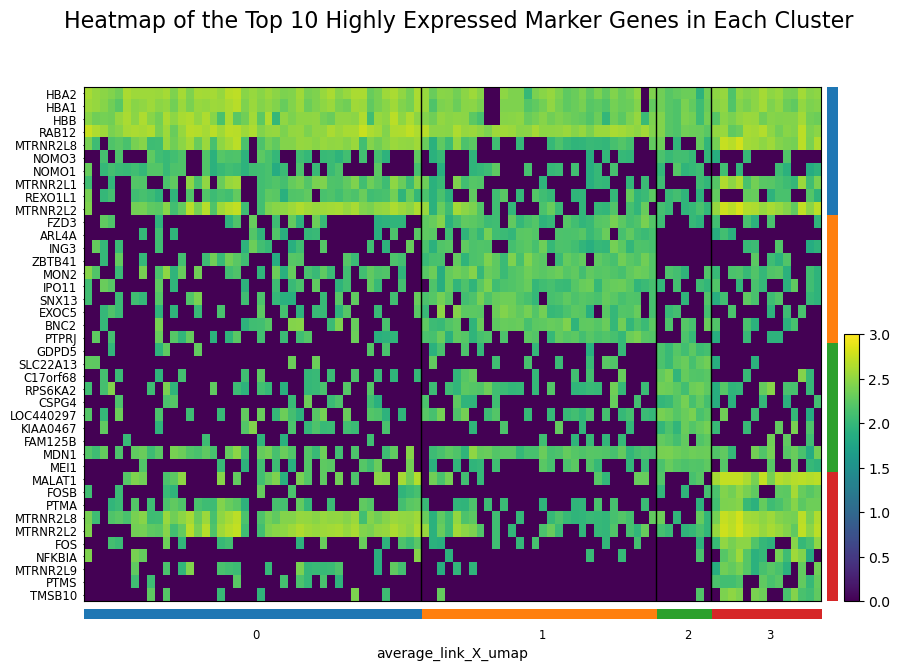

In [86]:
# Identifying the top 10 marker genes for each cluster based on the best clustering result from before
analysis.analyze_and_plot_markers(group_key='average_link_X_umap', method='wilcoxon', n_genes=10, filename='../data/marker_genes.csv')

We comment on these results further in our project report.

## 4.2. Functional Annotation of the Clusters using Gene Ontology (GO)

Gene Ontology (GO) is a framework for the standardized representation of gene and gene product attributes across species and databases. It categorizes functions into three main aspects: biological process, molecular function, and cellular component. Using GO for functional annotation of our clusters allows us to understand the biological significance of each cluster by identifying overrepresented functions and pathways. This provides insight on the roles of different cell populations and their contributions to the biological processes under study.

We used our `fetch_go_annotations` method in order to fetch the GO annotations for the top 10 highly expressed marker genes for each cluster from our best clustering results (UMAP with Average Linkage clustering), similarly to the authors' approach, and displayed our results using the `print_go_annotations` method, in order to compare the similarity of our results to theirs (the amount of overlap in GO annotations).

In [87]:
go_annotations = analysis.fetch_go_annotations(group_key='average_link_X_umap', method='wilcoxon', n_genes=10, organism='hsapiens') # fetching GO annotations for the top 10 marker genes for each cluster based on the best clustering results
analysis.print_go_annotations(go_annotations) # printing the GO annotations


GO annotations for group 0:


source      native                                               name  \
0  GO:CC  GO:0160064                      multi-pass translocon complex   
1  GO:CC  GO:0072379                      ER membrane insertion complex   
2     TF   TF:M06584                Factor: ZNF606; motif: GSCCTCTAGAAK   
3  GO:BP  GO:0160063  multi-pass transmembrane protein insertion int...   
4     TF   TF:M05758                Factor: ZNF699; motif: NGKATYAAAATA   
5  GO:BP  GO:0045048                 protein insertion into ER membrane   
6  GO:BP  GO:0051205                    protein insertion into membrane   
7     TF   TF:M05617                Factor: ZNF500; motif: NGTTCCGGGGRW   
8  GO:MF  GO:0043022                                   ribosome binding   
9     HP  HP:0034280                                       Target cells   

    p_value  significant                                        description  \
0  0.000081         True  "A protein complex that mediates the insertion...   
1  0.000205         True  "A protein complex that is involved in the pos...   
2  0.000490         True                Factor: ZNF606; motif: GSCCTCTAGAAK   
3  0.000651         True  "A process of protein insertion of multi-pass ...   
4  0.002122         True                Factor: ZNF699; motif: NGKATYAAAATA   
5  0.009532         True  "The process that results in incorporation of ...   
6  0.018669         True  "The process that results in the incorporation...   
7  0.045386         True                Factor: ZNF500; motif: NGTTCCGGGGRW   
8  0.046598         True         "Binding to a ribosome." [GOC:go_curators]   
9  0.049924         True  Target cells (codocytes) have a centrally loca...   

   term_size  query_size  intersection_size  effective_domain_size  precision  \
0          9           3                  2                  22097   0.666667   
1         14           3                  2                  22097   0.666667   
2          7           4                  2                  20045   0.500000   
3          9           4                  2                  21031   0.500000   
4         14           4                  2                  20045   0.500000   
5         33           4                  2                  21031   0.500000   
6         46           4                  2                  21031   0.500000   
7         63           4                  2                  20045   0.500000   
8        113           4                  2                  20212   0.500000   
9          1           1                  1                   4958   1.000000   

     recall    query                               parents  
0  0.222222  query_1                          [GO:0072379]  
1  0.142857  query_1              [GO:0005829, GO:0032991]  
2  0.285714  query_1                           [TF:M00000]  
3  0.222222  query_1                          [GO:0045048]  
4  0.142857  query_1                           [TF:M00000]  
5  0.060606  query_1  [GO:0007029, GO:0033365, GO:0051205]  
6  0.043478  query_1  [GO:0008104, GO:0061024, GO:0090150]  
7  0.031746  query_1                           [TF:M00000]  
8  0.017699  query_1                          [GO:0043021]  
9  1.000000  query_1                          [HP:0004447]


GO annotations for group 1:


Empty DataFrame
Columns: [source, native, name, p_value, significant, description, term_size, query_size, intersection_size, effective_domain_size, precision, recall, query, parents]
Index: []


GO annotations for group 2:


source      native                                           name   p_value  \
0  GO:MF  GO:0090416  nicotinate transmembrane transporter activity  0.049875   

   significant                                        description  term_size  \
0         True  "Enables the transfer of nicotinate from one s...          1   

   query_size  intersection_size  effective_domain_size  precision  recall  \
0           5                  1                  20212        0.2     1.0   

     query       parents  
0  query_1  [GO:0008028]


GO annotations for group 3:


source              native  \
0   KEGG          KEGG:04657   
1   KEGG          KEGG:04380   
2     WP           WP:WP2355   
3     WP           WP:WP4919   
4     WP           WP:WP2435   
5   REAC  REAC:R-HSA-9031628   
6   KEGG          KEGG:05031   
7   KEGG          KEGG:05140   
8  GO:BP          GO:0051412   
9     WP           WP:WP4880   

                                                name   p_value  significant  \
0                            IL-17 signaling pathway  0.000061         True   
1                         Osteoclast differentiation  0.000182         True   
2  Corticotropin releasing hormone signaling pathway  0.001089         True   
3                                  Neuroinflammation  0.001957         True   
4         Quercetin and Nf kB AP 1 induced apoptosis  0.003009         True   
5                       NGF-stimulated transcription  0.006812         True   
6                              Amphetamine addiction  0.009631         True   
7                                      Leishmaniasis  0.010491         True   
8                         response to corticosterone  0.011370         True   
9  Host pathogen interaction of human coronavirus...  0.013185         True   

                                         description  term_size  query_size  \
0                            IL-17 signaling pathway         92           3   
1                         Osteoclast differentiation        132           3   
2  Corticotropin releasing hormone signaling pathway         91           5   
3                                  Neuroinflammation         13           5   
4         Quercetin and Nf kB AP 1 induced apoptosis         16           5   
5                       NGF-stimulated transcription         39           3   
6                              Amphetamine addiction         69           3   
7                                      Leishmaniasis         72           3   
8  "Any process that results in a change in state...         16           7   
9  Host pathogen interaction of human coronavirus...         33           5   

   intersection_size  effective_domain_size  precision    recall    query  \
0                  3                   8484   1.000000  0.032609  query_1   
1                  3                   8484   1.000000  0.022727  query_1   
2                  3                   8286   0.600000  0.032967  query_1   
3                  2                   8286   0.400000  0.153846  query_1   
4                  2                   8286   0.400000  0.125000  query_1   
5                  2                  10842   0.666667  0.051282  query_1   
6                  2                   8484   0.666667  0.028986  query_1   
7                  2                   8484   0.666667  0.027778  query_1   
8                  2                  21031   0.285714  0.125000  query_1   
9                  2                   8286   0.400000  0.060606  query_1   

                                            parents  
0                                      [KEGG:00000]  
1                                      [KEGG:00000]  
2                                       [WP:000000]  
3                                       [WP:000000]  
4                                       [WP:000000]  
5                               [REAC:R-HSA-198725]  
6                                      [KEGG:00000]  
7                                      [KEGG:00000]  
8  [GO:0051384, GO:0051385, GO:0097305, GO:1901654]  
9                                       [WP:000000]

From these results, we can observe that 2 of the 4 clusters have fewer than 10 GO annotations (0 and 1). This can occur due to several reasons:

* Gene List Size: The list of top marker genes for a cluster may be small, especially if the cluster has few distinct marker genes.
* Statistical Significance: Not all genes will have statistically significant GO annotations. If the annotations do not meet the significance threshold, they might not be reported.
* Biological Context: Some genes may not have well-defined or annotated functions in the GO database, especially in less studied organisms or contexts.

We comment on these results further in our project report.

# Conclusions and Future Work

Our approach to the machine learning single-cell RNA-seq analysis is significantly more robust and extensive compared to the authors' methodology. While the authors relied solely on PCA for dimensionality reduction, followed by t-SNE visualization and hierarchical clustering without specifying a specific algorithm, our workflow incorporates multiple dimensionality reduction techniques (PCA, t-SNE, and UMAP) and evaluates their performance using a variety of clustering algorithms (GMM, Average Linkage, Ward, Spectral, Louvain, and Leiden). Additionally, we rigorously assess clustering quality with metrics like Silhouette Score, Calinski-Harabasz Index, and Davies-Bouldin Score. Our comprehensive pipeline also includes the identification of marker genes and functional annotation using Gene Ontology (GO), providing deeper biological insights into the cell populations. This multifaceted and thorough approach ensures more accurate and meaningful interpretations of the data, enhancing the overall robustness and reliability of the analysis. We are also in agreement with the authors that this methodology is useful for identifying cell heterogeneity though differential marker gene expression, which is why it is very important to base these findings on a good quality clustering result.

Some possible extensions of this analysis given more time could include:
* Improving the class so it can handle raw sequencing data, instead of starting from a counts matrix.
* Enrich the class so it can handle more clustering algorithms (e.g. DBSCAN) and/or evaluation metrics (e.g. BIC criterion)
* Perform pseudotime trajectory analysis of our clusters, similarly to the authors and compare with their results